#             *Compare and Merge Runs of well log data stored as las files*
---
---
## Load python libraries:

In [1]:

import warnings
warnings.filterwarnings("ignore")


import lasio
from lasio import CurveItem

import pandas as pd
import panel as pn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Import for manually creating colored legend labels


# Initialize Panel
pn.extension()

import base64
from io import BytesIO
#from IPython.core.display import display, HTML
from IPython.display import display, HTML



import glob


---
# Load las files stored in individual Subdirectories for each well:

Load Bakken wells located in subdirectories.

No logic yet to sort by well.

In [2]:
file_directory = "Bakken"
#file_directory = "16841-DeadwoodCanyon"
#file_directory = "16876-DeadwoodCanyon11-5h"
#file_directory = "17023-Braaflat-11-11h"
#file_directory = "well_29062"
#file_directory = "29062"
#file_directory = "18247"
#file_directory = "28036"
#file_directory = "27026"



files = "*.las"

las_files = sorted(glob.glob("./" + file_directory + "/" + files))

print("Files found:", las_files)  


Files found: ['./Bakken/17023-SOS1.las', './Bakken/CMR.las', './Bakken/Triple_Combo.las']


---
---
# Plot Presence of all available log curve data colored by las file

## First create an Andy McDonald type of depth plot that highlights the depths that have data for each log curve for each run colored by las file:

Andy has some great tutorials available on GitHub, LinkedIn and Medium. 

Plot saved as Depth_plot_Andy__Bakken_colored_by_las_file.png_colored_by_las_file


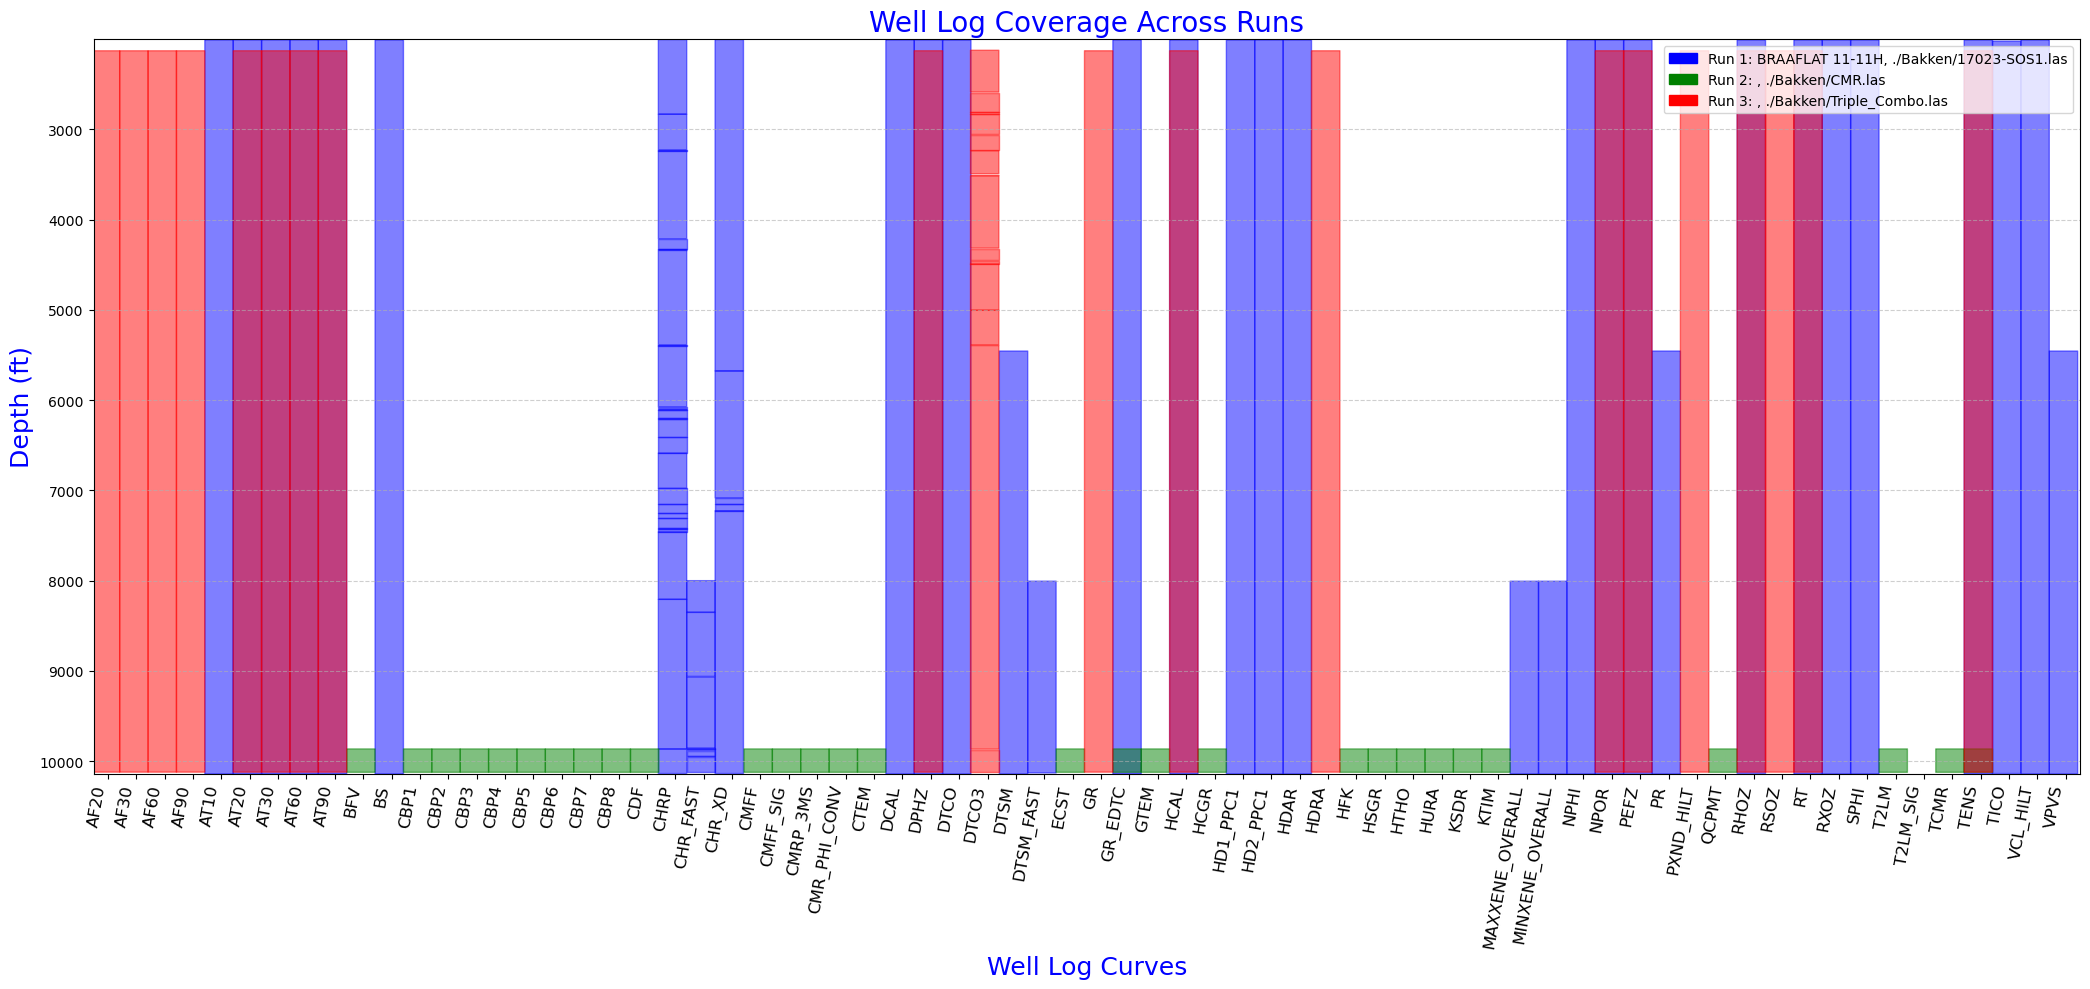

In [3]:
# Function to read LAS file and extract depth and log availability
def get_well_nan(file):
    las = lasio.read(file)
    df_log = las.df()
    df_log.index = las["DEPT"]
    well_nan = df_log.notnull().astype(int)  # Convert to binary (1=Available, 0=Missing)
    wellname = las.well.WELL.value if "WELL" in las.well else file  # Get well name
    return wellname, df_log.index, well_nan

# Read all LAS files and store data
las_data = [get_well_nan(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen"]
alpha = 0.5  # Transparency for shading

# Create figure with tracks for all unique curves
fig, ax = plt.subplots(figsize=(len(all_available_curves) * 0.3, 10))  # Increase width for better label spacing

# Well name storage for legend (with correct colors)
legend_patches = []

# Loop through each LAS file and shade where logs are present
for run_index, (wellname, depth, well_nan) in enumerate(las_data):
    legend_patches.append(mpatches.Patch(color=run_colors[run_index], label=f"Run {run_index+1}: {wellname}, {las_files[run_index]}"))    
    #legend_patches.append(mpatches.Patch(color=run_colors[run_index], label=f"Run {run_index+1}: {wellname}"))
    for j, curve in enumerate(all_available_curves):
        if curve in well_nan.columns:
            ax.fill_betweenx(depth, j - 0.6, j + 0.4, where=well_nan[curve] == 1, 
                             color=run_colors[run_index], alpha=alpha)

# Format plot
ax.set_xlim(-0.5, len(all_available_curves) - 0.5)  # Keep x-axis aligned
ax.set_ylim(max_depth, min_depth)  # Ensure depth increases downward
ax.set_xticks(range(len(all_available_curves)))
ax.set_xticklabels(all_available_curves, rotation=80, fontsize=12, ha="right")  # Rotate & align right
ax.set_xlabel("Well Log Curves", fontsize=18, color = 'blue')
ax.set_ylabel("Depth (ft)", fontsize=18, color = 'blue')
ax.set_title("Well Log Coverage Across Runs", fontsize=20, color='blue')
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Add well names to legend (ensuring correct colors)
ax.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True)

plt.subplots_adjust(bottom=0.25)  # Extra space for x-axis labels
plt.tight_layout()

# **Create output filenames using the well name**
wellname = wellname.replace("#", "").replace(" ", "_")  # Sanitize well name


# **Save the image**
'''image_filename = f"Depth_plot_Andy_{wellname}_{file_directory}_colored_by_las_file.png"'''
image_filename = f"Depth_plot_Andy_{wellname}_{file_directory}_colored_by_las_file.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}_colored_by_las_file")

plt.show()



## Plot each log curve with an x-range from the 5 percentile to the 95 percentile:

This is a start, but not perfect. Need to define log10 families of log curves.

Plot saved as Depth_plot__Bakken_colored_by_las_file.png



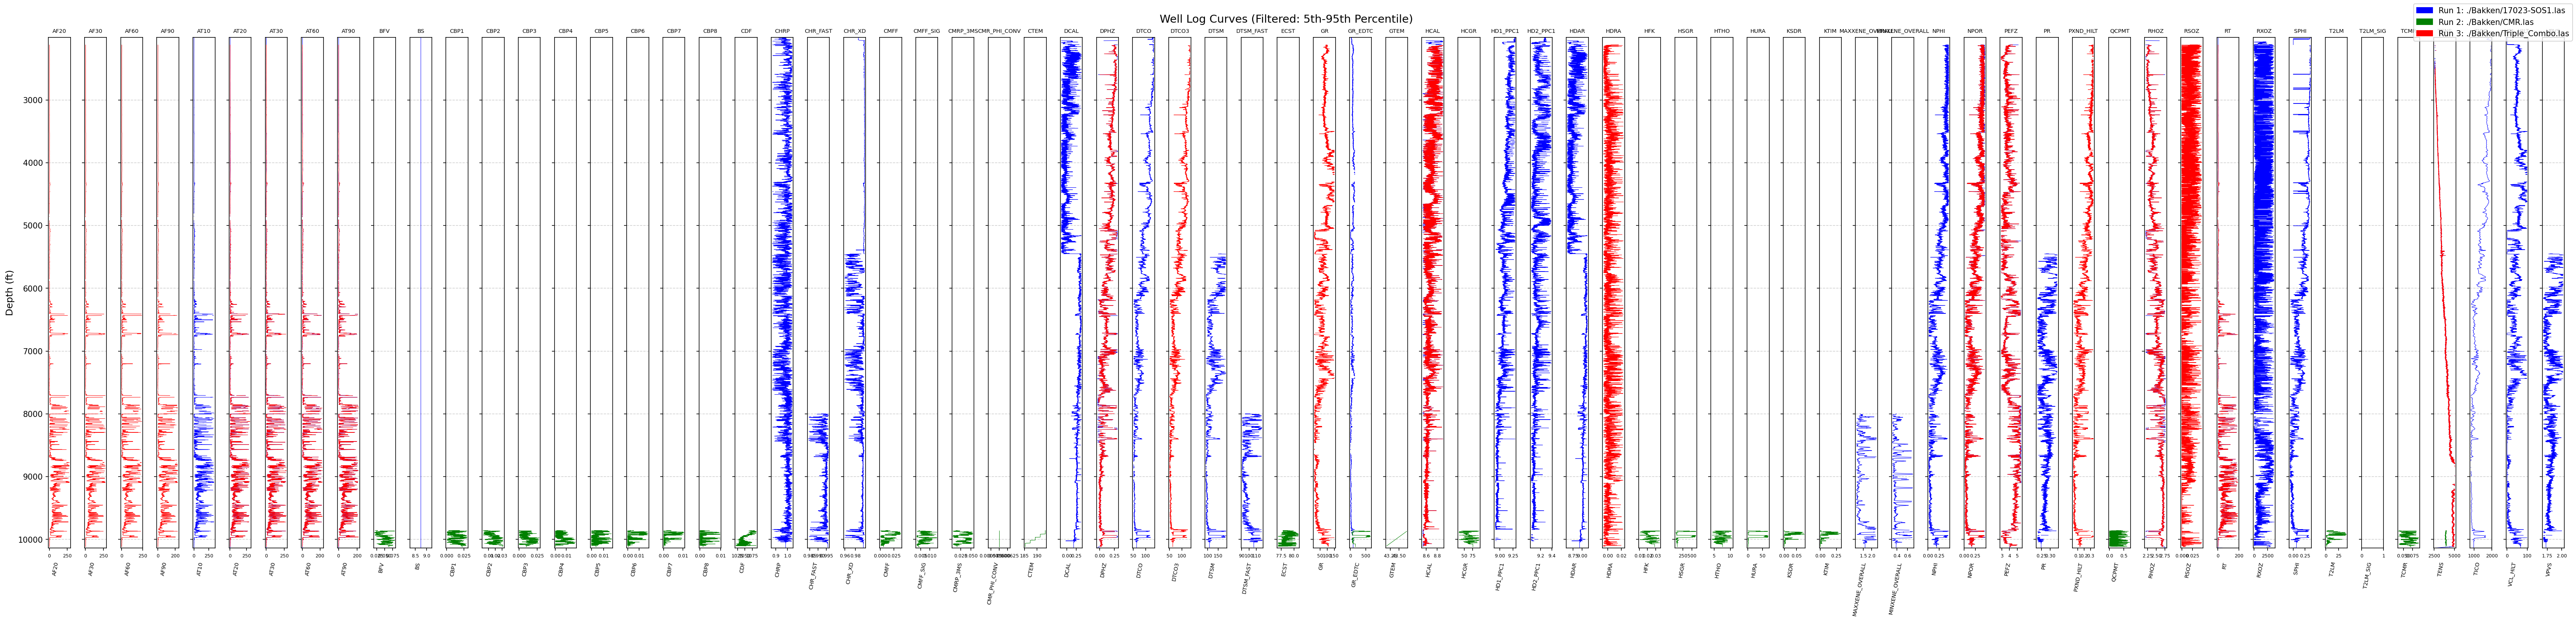

In [4]:
# Function to read LAS file and extract depth and log curves within 5th-95th percentile
def get_filtered_well_data(file):
    las = lasio.read(file)
    df_log = las.df()
    df_log.index = las["DEPT"]
    
    # Calculate 5th and 95th percentiles for each curve
    lower_bounds = df_log.quantile(0.05)
    upper_bounds = df_log.quantile(0.95)

    # Filter out extreme values outside the 5th-95th percentile range
    df_filtered = df_log.apply(lambda col: col.where((col >= lower_bounds[col.name]) & (col <= upper_bounds[col.name]), np.nan), axis=0)

    wellname = las.well.WELL.value if "WELL" in las.well else file  # Get well name
    return wellname, df_log.index, df_filtered

# Read all LAS files and store data
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen"]

# Create figure with tracks for all unique curves (reduce width for tighter spacing)
fig, axes = plt.subplots(nrows=1, ncols=len(all_available_curves), figsize=(len(all_available_curves) * .65, 11), sharey=True)

# Loop through each well log curve and plot it for each well
for i, curve in enumerate(all_available_curves):
    ax = axes[i]  # Assign subplot to this curve
    ax.set_title(curve, fontsize=7)

    # Check if this curve has data in **any** of the runs
    has_data = False

    # Plot filtered data for each run
    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        legend_patches.append(mpatches.Patch(color=run_colors[run_index], label=f"Run {run_index+1}: {wellname}, {las_files[run_index]}"))

        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth,  linewidth = 0.5 ,color=run_colors[run_index], label=f"{wellname}" if i == 0 else "")
            has_data = True  # Found data, so this track is not empty

    ## If no data exists for all runs, add a red flag 
    #if not has_data:
    #    ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  # This is the fix
    #####ax.invert_yaxis()  # Depth should increase downward
 
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  # Reduce x-axis tick label size
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves (Filtered: 5th-95th Percentile)", fontsize=14)

# Create custom legend entries (LAS file names with correct colors)
legend_patches = [mpatches.Patch(color=run_colors[i], label=f"Run {i+1}: {las_files[i]}") for i in range(len(las_files))]
fig.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True)


#fig.legend(loc="upper right", fontsize=10, frameon=True)
# Add well names to legend (ensuring correct colors)
#fig.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True)

plt.tight_layout(pad=1.0, w_pad=0.2)  # Reduce padding between subplots

# **Create output filenames using the well name**
wellname = wellname.replace("#", "").replace(" ", "_")  # Sanitize well name

# **Save the image**
'''image_filename = f"Depth_plot_{wellname}_{file_directory}_well_curves_colored_by_las_file.png"'''
image_filename = f"Depth_plot_{wellname}_{file_directory}_colored_by_las_file.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")



# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)  # Prevent double display in Jupyter

# Embed the image inside an HTML scrollable div (keeps everything in the notebook)
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""

# Display the scrollable plot in Jupyter Notebook
display(HTML(html_code))


---
---
# **Curve Inventory by LAS File**

## Typical report for all meta data for each las files:

Very simple display of well log header data in las file. 

In [5]:

# Loop through each LAS file
for file in las_files:
    print(f"\n=== Reviewing {file} ===")
    
    # Read in the LAS file
    las = lasio.read(file)
    
    # Print basic header information if available
    if las.version:
        print("LAS Version:", las.version)
    if las.well:
        print("Well Information:")
        for key, val in las.well.items():
            print(f"  {key}: {val.value} {val.unit if val.unit else ''}")
    
    # Print details of each curve
    print("\nWell Log Curves:")
    for curve in las.curves:
        print(f"  Mnemonic: {curve.mnemonic} | Unit: {curve.unit} | Description: {curve.descr}")
    
    # Extract the depth curve, assuming it's named "DEPT" or similar
    try:
        depth = las["DEPT"]
        print(f"\nDepth Range for {file}:")
        print(f"  Top (min): {depth.min()}")
        print(f"  Bottom (max): {depth.max()}")
    except KeyError:
        print("Depth curve ('DEPT') not found in this LAS file.")
    
    # Optionally, print a small sample of the data (first 5 rows)
    print("\nSample Data (first 5 rows):")
    # Build a list of selected curves to display (e.g., DEPT and others)
    sample_curves = ["DEPT"]  # start with depth
    # Add any other curves you expect to review (e.g., GR, RHOZ)
    for curve_name in ["GR", "RHOZ","TNPH"]:
        if curve_name in las.curves:
            sample_curves.append(curve_name)
    
    # Display the header for the sample table
    print("\t".join(sample_curves))
    # Get sample values
    for i in range(min(5, len(depth))):
        row_values = []
        for curve_name in sample_curves:
            try:
                # Format the value, if possible
                value = getattr(las[curve_name], "__getitem__")(i)
                row_values.append(f"{value:.2f}")
            except Exception:
                row_values.append("N/A")
        print("\t".join(row_values))



=== Reviewing ./Bakken/17023-SOS1.las ===
LAS Version: Mnemonic  Unit  Value                     Description                 
--------  ----  -----                     -----------                 
VERS            2.0                       CWLS LOG ASCII STANDARD     
WRAP            NO                        NO WRAP PERFORMED           
PROD            Schlumberger              LAS Producer                
CREA            Tue Apr  1 10:30:55 2008  LAS Creation Date and time  
Well Information:
  STRT: 10137.0 F
  STOP: 2003.0 F
  STEP: -0.5 F
  NULL: -999.25 
  COMP: WHITING OIL & GAS 
  WELL: BRAAFLAT 11-11H 
  FLD: WILDCAT 
  API: 33-061-00641 
  CNTY: MOUNTRAIL 
  STAT: N. DAKOTA 
  CTRY: US 
  LOC: NW NW 225' FNL & 550' FWL 
  SECT: 11 
  TOWN: 153 N 
  RANG: 91 W 
  LATI: 48.0953 N 
  LONG: 102.351 W 
  DATE: 24-Mar-2008 
  SRVC: Schlumberger 

Well Log Curves:
  Mnemonic: DEPT | Unit: F | Description: Depth Index
  Mnemonic: AT10 | Unit: OHMM | Description: 1 AIT TWO FOOT RESIST

---
# **Panel used to create summary reports by las file:**

We can create more of a dashboard here.

In [6]:
# Function to process and display LAS file data
def review_las(file):
    # Read in the LAS file
    las = lasio.read(file)
    
    # Extract well information
    well_info = {}
    if las.well:
        for key, val in las.well.items():
            well_info[key] = f"{val.value} {val.unit}" if val.unit else val.value
    
    # Extract curve details
    curve_details = pd.DataFrame([
        {"Mnemonic": curve.mnemonic, "Unit": curve.unit, "Description": curve.descr}
        for curve in las.curves
    ])

    # Extract depth range
    try:
        depth = las["DEPT"]
        depth_range = {
            "Top Depth (Min)": depth.min(),
            "Bottom Depth (Max)": depth.max()
        }
    except KeyError:
        depth_range = {"Error": "Depth curve ('DEPT') not found"}

    # Extract sample data
    sample_curves = ["DEPT"]
    for curve_name in ["GR", "RHOZ","NPOR","RT","RS"]:
        if curve_name in las.keys():
            sample_curves.append(curve_name)

    sample_data = pd.DataFrame({curve: las[curve][:5] for curve in sample_curves})

    # Create interactive Panel layout
    layout = pn.Column(
        f"### Reviewing {file}",
        pn.pane.Markdown(f"#### Well Information"),
        pn.pane.DataFrame(pd.DataFrame.from_dict(well_info, orient='index', columns=['Value']), width=500),
        pn.pane.Markdown("#### LAS Well Log Curves"),
        pn.pane.DataFrame(curve_details, width=600),
        pn.pane.Markdown("#### Depth Range"),
        pn.pane.DataFrame(pd.DataFrame.from_dict(depth_range, orient='index', columns=['Value']), width=400),
        pn.pane.Markdown("#### Sample Data (First 5 Rows)"),
        pn.pane.DataFrame(sample_data, width=500)
    )

    return layout

# Create dropdown for LAS file selection
file_selector = pn.widgets.Select(name="Select LAS File", options=las_files)

# Display the selected LAS file details
dashboard = pn.Column(
    "# Well Log Review by LAS File",
    file_selector,
    pn.bind(review_las, file_selector)  # Dynamically update output based on selection
)

# Display the dashboard in the Jupyter Notebook
dashboard.servable()


Column
    [0] Markdown(str)
    [1] Select(options=['./Bakken/17023-SOS1.las'...], value='./Bakken/17023-SOS1.las')
    [2] ParamFunction(function, _pane=Column, defer_load=False)

---
---
# **Just a start on a Generalized Depth plots:**

## Depth plot of a few pre-defined well log curves for all run data to use as simple example.

Simple example at first:

Run                       File  Depth Min (ft)  Depth Max (ft)  \
0    1    ./Bakken/17023-SOS1.las            9500           10900   
1    2           ./Bakken/CMR.las            9500           10900   
2    3  ./Bakken/Triple_Combo.las            9500           10900   

                                    Available Curves  
0  DEPT, AT10, AT20, AT30, AT60, AT90, RT, RXOZ, ...  
1  DEPT, BFV, CBP1, CBP2, CBP3, CBP4, CBP5, CBP6,...  
2  DEPT, AF20, AF30, AF60, AF90, AT20, AT30, AT60...

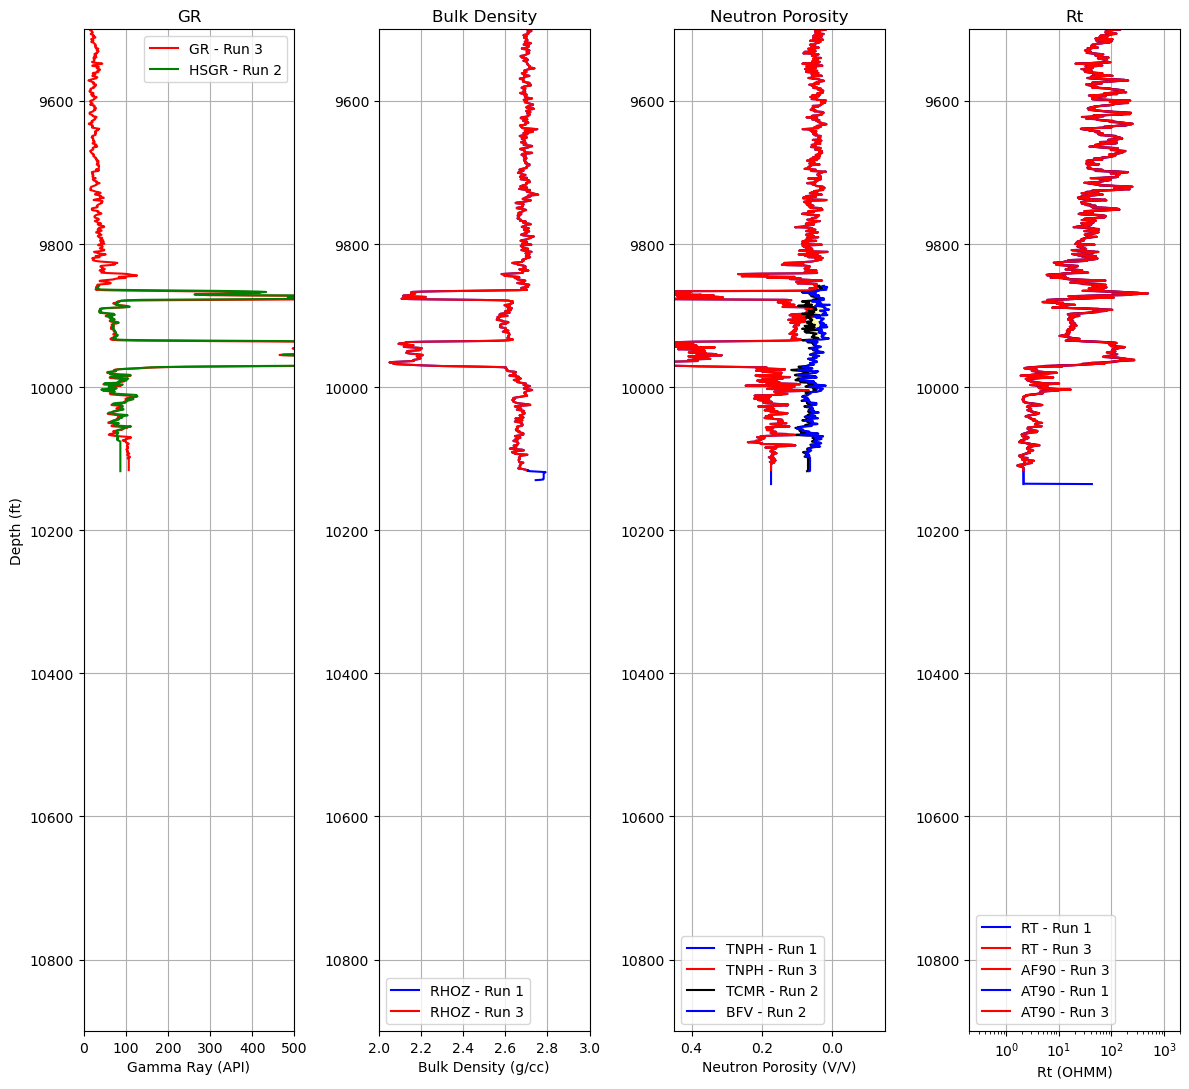

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasio

top_depth = 9500
bottom_depth = 10900

# Initialize storage for data
logs = []

# Read LAS files and extract data
for file in las_files:
    las = lasio.read(file)

    # Extract depth range
    depth_min = top_depth
    depth_max = bottom_depth

    # Store log names and depth ranges
    curve_info = {
        curve.mnemonic: (las[curve.mnemonic].min(), las[curve.mnemonic].max())
        for curve in las.curves
    }

    # Store log data
    logs.append({
        "file": file,
        "depth": las["DEPT"],
        "GR": las["GR"] if "GR" in las.curves else None,
        "HSGR": las["HSGR"] if "HSGR" in las.curves else None,
        "RHOZ": las["RHOZ"] if "RHOZ" in las.curves else None,
        "TNPH": las["NPOR"] if "NPOR" in las.curves else None,
        "TCMR": las["TCMR"] if "TCMR" in las.curves else None,
        "BFV": las["BFV"] if "BFV" in las.curves else None,
        "RT": las["RT"] if "RT" in las.curves else None,
        "AF90": las["AF90"] if "AF90" in las.curves else None,
        "AT90": las["AT90"] if "AT90" in las.curves else None,

        "depth_min": depth_min,
        "depth_max": depth_max,
        "curves": curve_info
    })

# Create a summary table
df_summary = pd.DataFrame([
    {
        "Run": i + 1,
        "File": log["file"],
        "Depth Min (ft)": log["depth_min"],
        "Depth Max (ft)": log["depth_max"],
        "Available Curves": ", ".join(log["curves"].keys())
    }
    for i, log in enumerate(logs)
])

display(df_summary)

# Function to plot logs
def plot_well_logs():
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 11), sharey=False)

    colors = ["blue", "green", "red", "orange", "yellow", "black",
              "purple", "cyan", "gray", "violet", "limegreen"]

    # ---------------- Track 1: GR ----------------
    for i, log in enumerate(logs):
        if log["GR"] is not None:
            axes[0].plot(log["GR"], log["depth"], color=colors[i], label=f"GR - Run {i+1}")
    for i, log in enumerate(logs):
        if log["HSGR"] is not None:
            axes[0].plot(log["HSGR"], log["depth"], color=colors[i], label=f"HSGR - Run {i+1}")

    axes[0].set_ylim(top_depth, bottom_depth)
    axes[0].invert_yaxis()
    axes[0].set_xlim(0, 500)

    axes[0].set_xlabel("Gamma Ray (API)")
    axes[0].set_ylabel("Depth (ft)")
    axes[0].set_title("GR")
    axes[0].grid()
    axes[0].legend()

    # ---------------- Track 2: Density ----------------
    for i, log in enumerate(logs):
        if log["RHOZ"] is not None:
            axes[1].plot(log["RHOZ"], log["depth"], color=colors[i], label=f"RHOZ - Run {i+1}")

    axes[1].set_ylim(top_depth, bottom_depth)
    axes[1].invert_yaxis()
    axes[1].set_xlabel("Bulk Density (g/cc)")
    axes[1].set_title("Bulk Density")
    axes[1].set_xlim(2, 3)
    axes[1].grid()
    axes[1].legend()

    # ---------------- Track 3: Neutron / NMR ----------------
    for i, log in enumerate(logs):
        if log["TNPH"] is not None:
            axes[2].plot(log["TNPH"], log["depth"], color=colors[i], label=f"TNPH - Run {i+1}")

    for i, log in enumerate(logs):
        if log["TCMR"] is not None:
            axes[2].plot(log["TCMR"], log["depth"], color="black", label=f"TCMR - Run {i+1}")

    for i, log in enumerate(logs):
        if log["BFV"] is not None:
            axes[2].plot(log["BFV"], log["depth"], color="blue", label=f"BFV - Run {i+1}")

    # ---- Yellow fill between TCMR and BFV (NO LABELS) ----
    for i, log in enumerate(logs):
        if log["TCMR"] is not None and log["BFV"] is not None:

            depth = np.asarray(log["depth"], dtype=float)
            tcmr  = np.asarray(log["TCMR"], dtype=float)
            bfv   = np.asarray(log["BFV"], dtype=float)

            m = (
                (depth >= top_depth) &
                (depth <= bottom_depth) &
                np.isfinite(tcmr) &
                np.isfinite(bfv)
            )

            if np.any(m):
                axes[2].fill_betweenx(
                    depth[m],
                    tcmr[m],
                    bfv[m],
                    color="yellow",
                    alpha=0.35
                )

    axes[2].set_ylim(top_depth, bottom_depth)
    axes[2].invert_yaxis()
    axes[2].set_xlabel("Neutron Porosity (V/V)")
    axes[2].set_title("Neutron Porosity")
    axes[2].set_xlim(0.45, -0.15)
    axes[2].grid()
    axes[2].legend()

    # ---------------- Track 4: Resistivity ----------------
    for i, log in enumerate(logs):
        if log["RT"] is not None:
            axes[3].plot(log["RT"], log["depth"], color=colors[i], label=f"RT - Run {i+1}")
    for i, log in enumerate(logs):
        if log["AF90"] is not None:
            axes[3].plot(log["AF90"], log["depth"], color=colors[i], label=f"AF90 - Run {i+1}")
    for i, log in enumerate(logs):
        if log["AT90"] is not None:
            axes[3].plot(log["AT90"], log["depth"], color=colors[i], label=f"AT90 - Run {i+1}")

    axes[3].set_ylim(top_depth, bottom_depth)
    axes[3].invert_yaxis()
    axes[3].set_xlabel("Rt (OHMM)")
    axes[3].set_title("Rt")
    axes[3].set_xscale("log")
    axes[3].set_xlim(0.2, 2000)
    axes[3].grid()
    axes[3].legend()

    plt.tight_layout()
    plt.show()







# Execute
plot_well_logs()


# Define Curve Families:

Run                       File  Depth Min (ft)  Depth Max (ft)  \
0    1    ./Bakken/17023-SOS1.las            9500           10900   
1    2           ./Bakken/CMR.las            9500           10900   
2    3  ./Bakken/Triple_Combo.las            9500           10900   

                                    Available Curves  
0  DEPT, AT10, AT20, AT30, AT60, AT90, RT, RXOZ, ...  
1  DEPT, BFV, CBP1, CBP2, CBP3, CBP4, CBP5, CBP6,...  
2  DEPT, AF20, AF30, AF60, AF90, AT20, AT30, AT60...

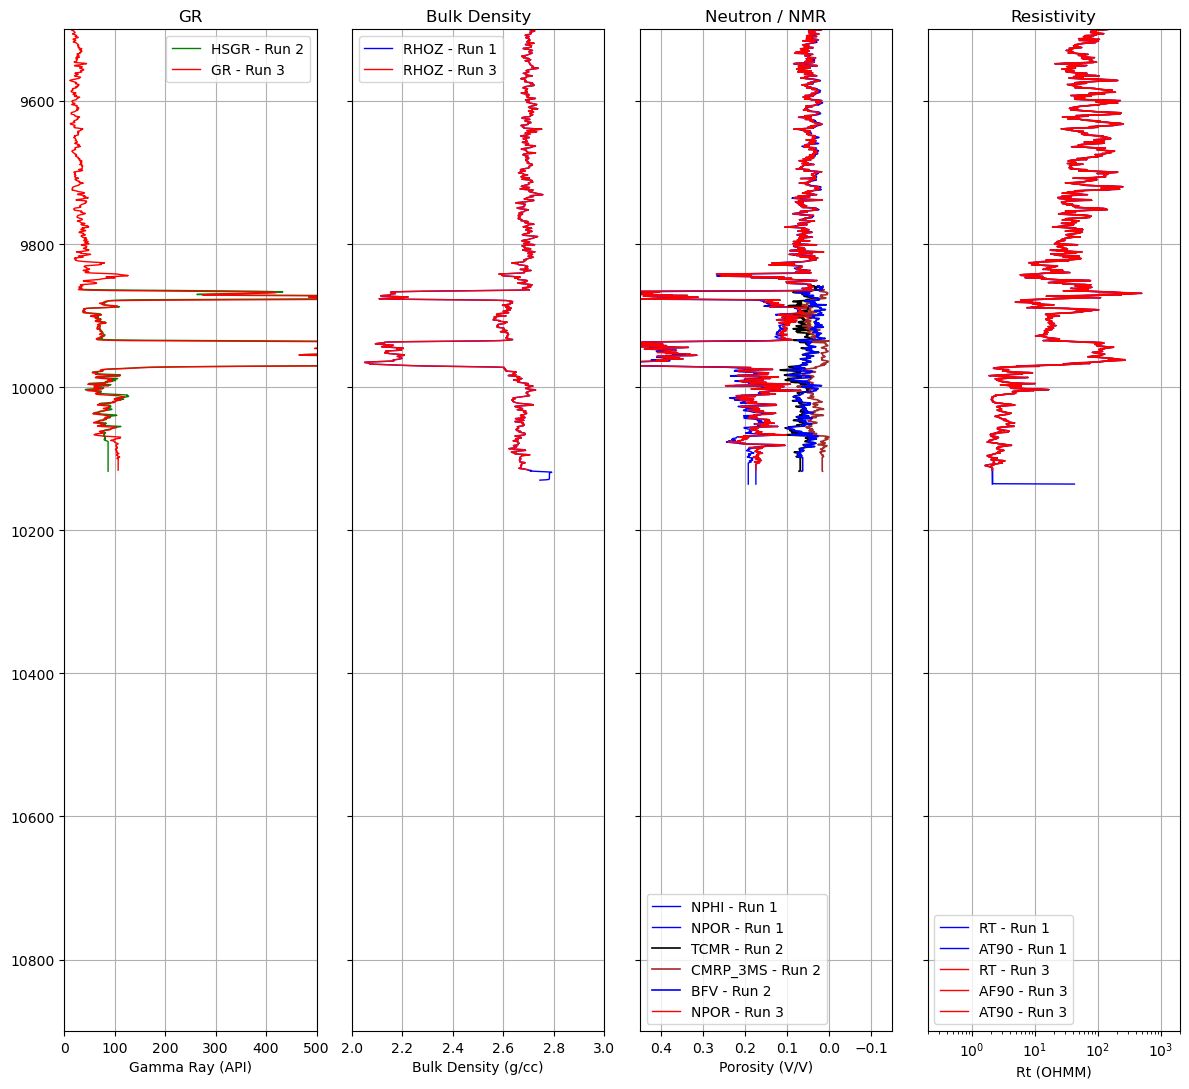

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasio

top_depth = 9500
bottom_depth = 10900

# -----------------------------
# 1) Define curve families
# -----------------------------



curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],
    "RHOB":    ["RHOB", "RHOZ"],
    "DRHO":    ["DRHO", "HDRA", "HDRH"],
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"],

    # Caliper (hole diameter, inches) — prefer the full-coverage HD curves first
    "CALI":    ["HD1_PPC1", "HD2_PPC1", "CALI", "HCAL", "C1", "C2"],

    "DCAL":    ["DCAL"],
    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],
    "RT":      ["RT", "AF90", "AT90", "AO90"],
}






# Optional per-curve styling overrides
curve_style = {
    "TCMR":     {"color": "black", "linewidth": 1.2},
    "CMRP_3MS": {"color": "brown", "linewidth": 1.2},
    "BFV":      {"color": "blue",  "linewidth": 1.2},
}

# Yellow fill spec
fill_between = {
    "track": "POR_NMR",
    "left": "TCMR",
    "right": "BFV",
    "color": "yellow",
    "alpha": 0.35
}

# -----------------------------
# 2) Read LAS files
# -----------------------------
logs = []

for file in las_files:
    las = lasio.read(file)

    curve_info = {
        curve.mnemonic: (las[curve.mnemonic].min(), las[curve.mnemonic].max())
        for curve in las.curves
    }

    data = {
        "file": file,
        "depth": las["DEPT"],
        "depth_min": top_depth,
        "depth_max": bottom_depth,
        "curves": curve_info
    }

    needed = set(mn for fam in curve_families.values() for mn in fam)
    for mn in needed:
        data[mn] = las[mn] if mn in las.curves else None

    logs.append(data)

# -----------------------------
# 3) Summary table
# -----------------------------
df_summary = pd.DataFrame([
    {
        "Run": i + 1,
        "File": log["file"],
        "Depth Min (ft)": log["depth_min"],
        "Depth Max (ft)": log["depth_max"],
        "Available Curves": ", ".join(log["curves"].keys())
    }
    for i, log in enumerate(logs)
])

display(df_summary)

# -----------------------------
# 4) Plot helpers
# -----------------------------
def plot_track(ax, track_keys, xlim=None, xscale=None, xlabel="", title=""):
    # If you have many runs, modulo indexing prevents IndexError
    colors = ["blue", "green", "red", "orange", "purple", "cyan", "gray", "violet", "limegreen", "teal"]

    if isinstance(track_keys, str):
        track_keys = [track_keys]

    mnemonics = []
    for key in track_keys:
        mnemonics.extend(curve_families.get(key, []))

    for i, log in enumerate(logs):
        depth = log["depth"]

        for mn in mnemonics:
            if log.get(mn) is None:
                continue

            # Default style: run color (safe for any number of runs)
            style = {"color": colors[i % len(colors)], "linewidth": 1.0}

            # Override if specified (e.g., TCMR black, BFV blue)
            if mn in curve_style:
                style.update(curve_style[mn])

            ax.plot(log[mn], depth, label=f"{mn} - Run {i+1}", **style)

    ax.set_ylim(top_depth, bottom_depth)
    ax.invert_yaxis()
    if xlim is not None:
        ax.set_xlim(*xlim)
    if xscale is not None:
        ax.set_xscale(xscale)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid()
    ax.legend()

def add_fill_between(ax):
    left = fill_between["left"]
    right = fill_between["right"]

    for log in logs:
        if log.get(left) is None or log.get(right) is None:
            continue

        depth = np.asarray(log["depth"], float)
        x1 = np.asarray(log[left], float)
        x2 = np.asarray(log[right], float)

        m = (
            (depth >= top_depth) &
            (depth <= bottom_depth) &
            np.isfinite(x1) &
            np.isfinite(x2)
        )

        if np.any(m):
            ax.fill_betweenx(
                depth[m],
                x1[m],
                x2[m],
                color=fill_between["color"],
                alpha=fill_between["alpha"]
            )

# -----------------------------
# 5) Plot function
# -----------------------------
def plot_well_logs():
    fig, axes = plt.subplots(1, 4, figsize=(12, 11), sharey=True)

    # Track 1: GR
    plot_track(
        axes[0],
        "GR",
        xlim=(0.0, 500),
        xlabel="Gamma Ray (API)",
        title="GR"
    )

    # Track 2: Density
    plot_track(
        axes[1],
        "RHOB",
        xlim=(2, 3),
        xlabel="Bulk Density (g/cc)",
        title="Bulk Density"
    )

    # Track 3: TNPH + NMR
    plot_track(
        axes[2],
        ["TNPH", "POR_NMR"],
        xlim=(0.45, -0.15),
        xlabel="Porosity (V/V)",
        title="Neutron / NMR"
    )
    add_fill_between(axes[2])

    # Track 4: Resistivity
    plot_track(
        axes[3],
        "RT",
        xlim=(0.2, 2000),
        xscale="log",
        xlabel="Rt (OHMM)",
        title="Resistivity"
    )

    plt.tight_layout()
    plt.show()





# Execute
plot_well_logs()


---
---
# **Merge all las file Data:**

Fit any combination of runs.

First plot the merged data as black curves to make sure that this is working:

Plot saved as Merged_Depth_plot__Bakken_black&white.png



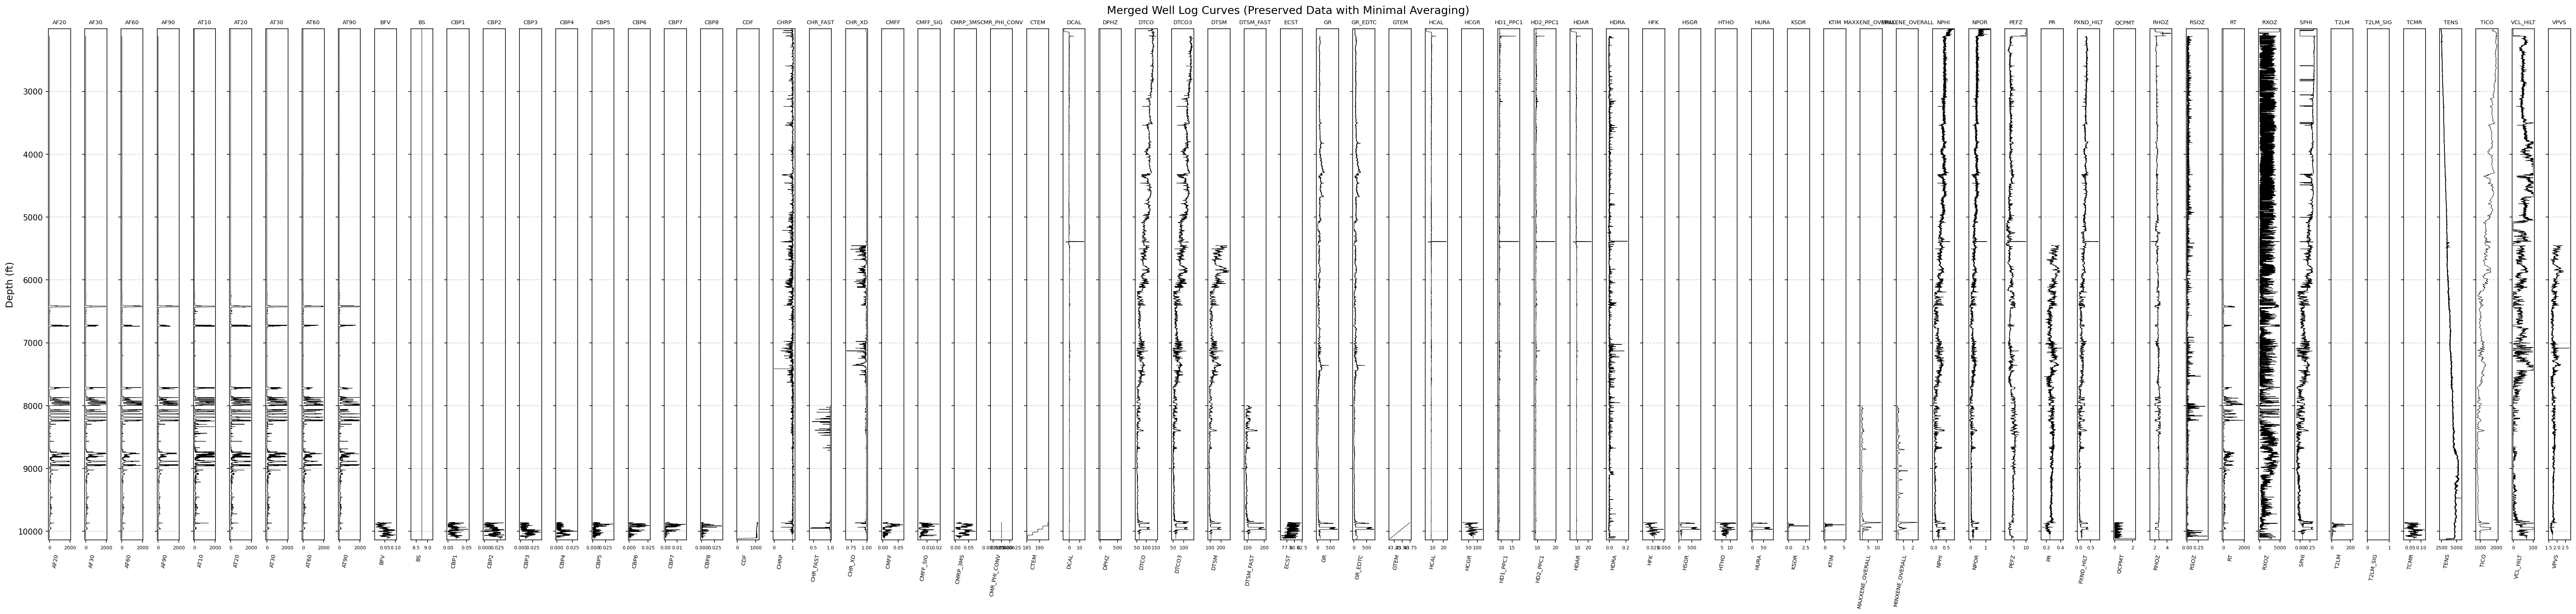

In [9]:
# this might not plot well, but I think the data might be good.

import numpy as np
import pandas as pd
import lasio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from io import BytesIO
import base64
from IPython.display import display, HTML  

# Function to read LAS file and extract depth/log data
def get_filtered_well_data(file):
    las = lasio.read(file)
    df_log = las.df()
    
    # Ensure depth is unique by averaging duplicate values
    df_log = df_log.groupby("DEPT").mean().reset_index()
    df_log.set_index("DEPT", inplace=True)

    wellname = las.well.WELL.value if "WELL" in las.well else file  
    return wellname, df_log.index, df_log

# Read all LAS files
las_data = [get_filtered_well_data(file) for file in las_files]

# **Ensure all depths from all LAS files are included in `merged_depth_index`**
all_depths = np.unique(np.concatenate([depth.values for _, depth, _ in las_data]))
merged_depth_index = np.sort(all_depths)  # Ensure sorted order

# Get all unique well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Create an empty DataFrame for merged data
merged_df = pd.DataFrame(index=merged_depth_index, columns=all_available_curves)

# **Improved Merging Strategy: Preserve Original Data**
for _, depth, df_log in las_data:
    df_log = df_log.loc[~df_log.index.duplicated(keep="first")]  # Ensure unique depth values

    # Find the depth range for this run
    depth_min, depth_max = df_log.index.min(), df_log.index.max()
    
    # Assign data where it does not already exist
    for curve in all_available_curves:
        if curve in df_log.columns:
            valid_mask = df_log[curve].notna()
            valid_depths = df_log.index[valid_mask]
            
            # If the curve does not exist in merged_df, assign it directly
            if merged_df.loc[valid_depths, curve].isna().all():
                merged_df.loc[valid_depths, curve] = df_log.loc[valid_depths, curve]
            else:
                # **Merge using a weighted approach in overlapping regions**
                overlap_mask = merged_df.loc[valid_depths, curve].notna()
                
                # **Prioritize existing values over interpolated ones**
                merged_df.loc[valid_depths[~overlap_mask], curve] = df_log.loc[valid_depths[~overlap_mask], curve]
                
                # **For overlapping depths, favor the newer run's values over global averaging**
                merged_df.loc[valid_depths[overlap_mask], curve] = (
                    df_log.loc[valid_depths[overlap_mask], curve] * 0.7 +  # Prioritize new data
                    merged_df.loc[valid_depths[overlap_mask], curve] * 0.3  # Blend older data slightly
                )

# **Plot the merged well log curves**
fig, axes = plt.subplots(nrows=1, ncols=len(all_available_curves), figsize=(len(all_available_curves) * 0.65, 11), sharey=True)

for i, curve in enumerate(all_available_curves):
    ax = axes[i]
    ax.set_title(curve, fontsize=7)

    # Plot the merged curve
    if curve in merged_df.columns and merged_df[curve].notna().any():
        ax.plot(merged_df[curve], merged_depth_index, linewidth=0.5, color="black")  # Final merged curve in black

    # Formatting
    ax.set_ylim(merged_depth_index[-1], merged_depth_index[0])  # Ensure depth increases downward
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  
    ax.grid(axis="y", linestyle="--", alpha=0.6)




# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Merged Well Log Curves (Preserved Data with Minimal Averaging)", fontsize=14)

# **Create output filenames using the well name**
wellname = wellname.replace("#", "").replace(" ", "_")  # Sanitize well name

# Save and display the image
plt.tight_layout(pad=1.0, w_pad=0.2)
'''image_filename = f"Merged_Depth_plot_{wellname}_{file_directory}.png"'''
image_filename = f"Merged_Depth_plot_{wellname}_{file_directory}_black&white.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


## **QC Check** - *merged data as thin yellow curves plotted over individual runs color by las file:*

Plot saved as Merged_Depth_plot__Bakken_yellow-line_plotted-over-colored-individual-las-files_QC-check.png



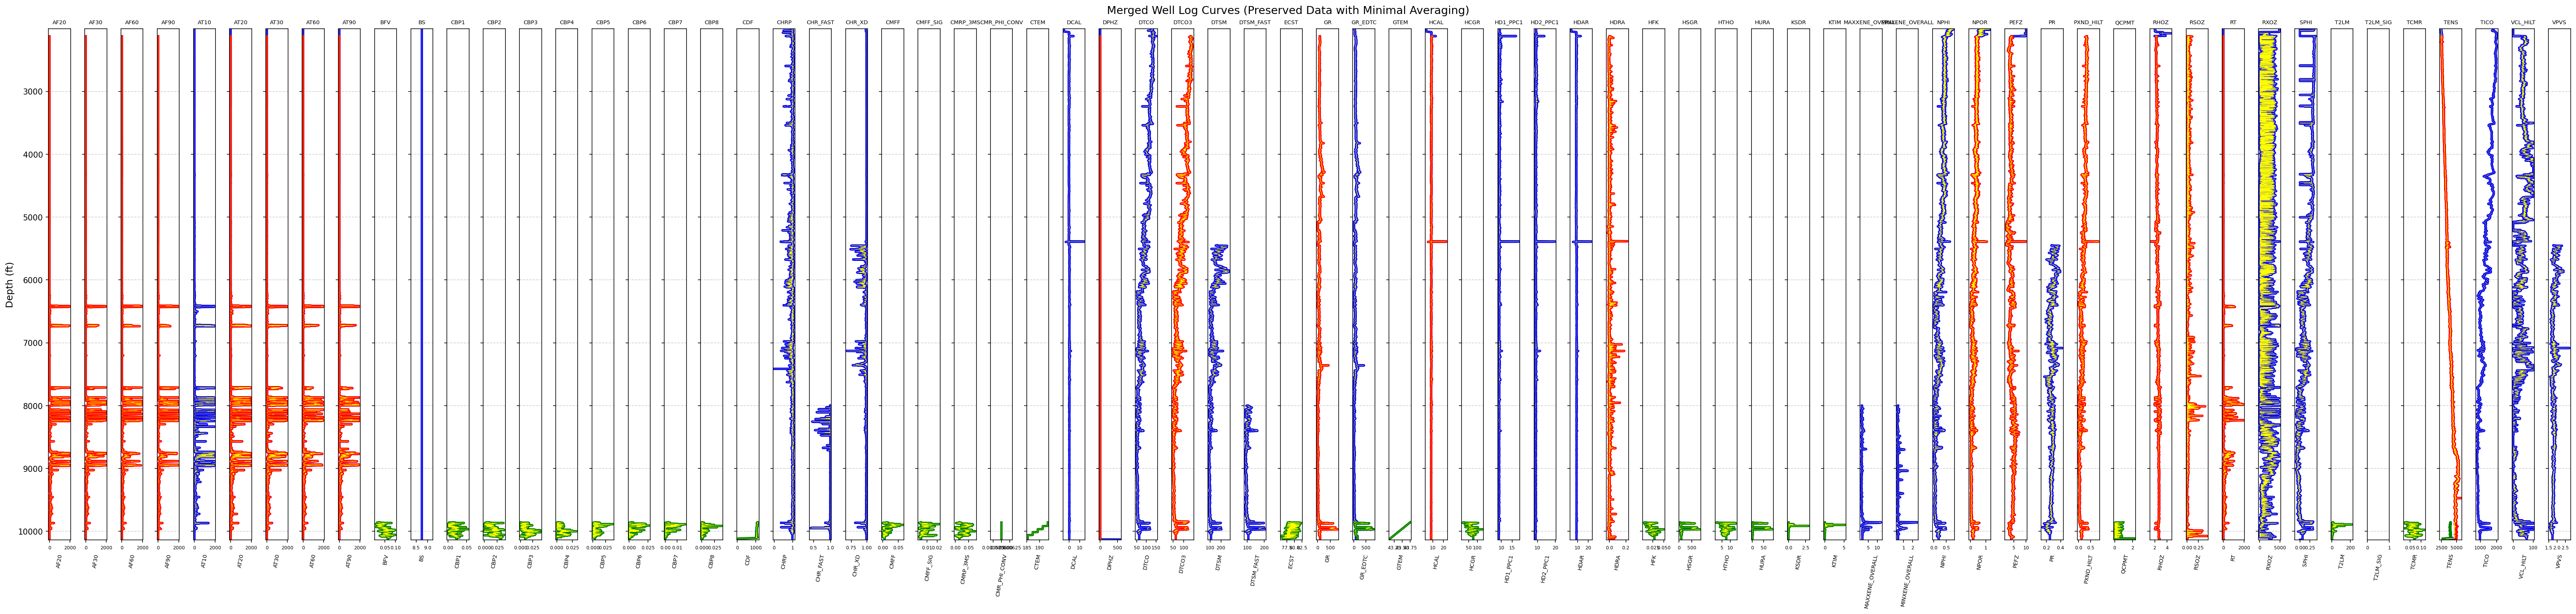

In [10]:
# this might not plot well, but I think the data might be good.

import numpy as np
import pandas as pd
import lasio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from io import BytesIO
import base64
from IPython.display import display, HTML  

# Function to read LAS file and extract depth/log data
def get_filtered_well_data(file):
    las = lasio.read(file)
    df_log = las.df()
    
    # Ensure depth is unique by averaging duplicate values
    df_log = df_log.groupby("DEPT").mean().reset_index()
    df_log.set_index("DEPT", inplace=True)

    wellname = las.well.WELL.value if "WELL" in las.well else file  
    return wellname, df_log.index, df_log

# Read all LAS files
las_data = [get_filtered_well_data(file) for file in las_files]

# **Ensure all depths from all LAS files are included in `merged_depth_index`**
all_depths = np.unique(np.concatenate([depth.values for _, depth, _ in las_data]))
merged_depth_index = np.sort(all_depths)  # Ensure sorted order

# Get all unique well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Create an empty DataFrame for merged data
merged_df = pd.DataFrame(index=merged_depth_index, columns=all_available_curves)

# **Improved Merging Strategy: Preserve Original Data**
for _, depth, df_log in las_data:
    df_log = df_log.loc[~df_log.index.duplicated(keep="first")]  # Ensure unique depth values

    # Find the depth range for this run
    depth_min, depth_max = df_log.index.min(), df_log.index.max()
    
    # Assign data where it does not already exist
    for curve in all_available_curves:
        if curve in df_log.columns:
            valid_mask = df_log[curve].notna()
            valid_depths = df_log.index[valid_mask]
            
            # If the curve does not exist in merged_df, assign it directly
            if merged_df.loc[valid_depths, curve].isna().all():
                merged_df.loc[valid_depths, curve] = df_log.loc[valid_depths, curve]
            else:
                # **Merge using a weighted approach in overlapping regions**
                overlap_mask = merged_df.loc[valid_depths, curve].notna()
                
                # **Prioritize existing values over interpolated ones**
                merged_df.loc[valid_depths[~overlap_mask], curve] = df_log.loc[valid_depths[~overlap_mask], curve]
                
                # **For overlapping depths, favor the newer run's values over global averaging**
                merged_df.loc[valid_depths[overlap_mask], curve] = (
                    df_log.loc[valid_depths[overlap_mask], curve] * 0.7 +  # Prioritize new data
                    merged_df.loc[valid_depths[overlap_mask], curve] * 0.3  # Blend older data slightly
                )

# **Plot the merged well log curves**
fig, axes = plt.subplots(nrows=1, ncols=len(all_available_curves), figsize=(len(all_available_curves) * 0.65, 11), sharey=True)

for i, curve in enumerate(all_available_curves):
    ax = axes[i]
    ax.set_title(curve, fontsize=7)


    # Colored plots by run

    # Check if this curve has data in **any** of the runs
    has_data = False

    # Plot filtered data for each run
    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        legend_patches.append(mpatches.Patch(color=run_colors[run_index], label=f"Run {run_index+1}: {wellname}, {las_files[run_index]}"))

        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth,  linewidth = 3 ,color=run_colors[run_index], label=f"{wellname}" if i == 0 else "")
            has_data = True  # Found data, so this track is not empty


    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  # This is the fix
    #####ax.invert_yaxis()  # Depth should increase downward
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  # Reduce x-axis tick label size
    ax.grid(axis="y", linestyle="--", alpha=0.6)





    # Plot the merged curve
    if curve in merged_df.columns and merged_df[curve].notna().any():
        ax.plot(merged_df[curve], merged_depth_index, linewidth=0.25, color="yellow", alpha=1)  # Final merged curve in black

    # Formatting
    ax.set_ylim(merged_depth_index[-1], merged_depth_index[0])  # Ensure depth increases downward
    ax.set_xlabel(curve, fontsize=7)  
    ax.tick_params(axis="x", labelsize=6)  
    ax.grid(axis="y", linestyle="--", alpha=0.6)





# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Merged Well Log Curves (Preserved Data with Minimal Averaging)", fontsize=14)

# **Create output filenames using the well name**
wellname = wellname.replace("#", "").replace(" ", "_")  # Sanitize well name

# Save and display the image
plt.tight_layout(pad=1.0, w_pad=0.2)
'''image_filename = f"Merged_Depth_plot_{wellname}_{file_directory}.png"'''
image_filename = f"Merged_Depth_plot_{wellname}_{file_directory}_yellow-line_plotted-over-colored-individual-las-files_QC-check.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


---
---
# **Save Merged data to las and csv files:**

In [11]:
# **Extract well metadata from the first LAS file**
las_first = lasio.read(las_files[0])  # Read first LAS file

# **Retain Well Information**
well_metadata = {
    "COMPANY": las_first.well.COMP.value if "COMP" in las_first.well else "Unknown",
    "WELL": las_first.well.WELL.value if "WELL" in las_first.well else "Unknown",
    "FIELD": las_first.well.FLD.value if "FLD" in las_first.well else "Unknown",
    "LOCATION": las_first.well.LOC.value if "LOC" in las_first.well else "Unknown",
    "COUNTY": las_first.well.CNTY.value if "CNTY" in las_first.well else "Unknown",
    "STATE": las_first.well.STAT.value if "STAT" in las_first.well else "Unknown",
    "COUNTRY": las_first.well.CTRY.value if "CTRY" in las_first.well else "Unknown",
    "SERVICE_COMPANY": las_first.well.SRVC.value if "SRVC" in las_first.well else "Unknown",
    "LATITUDE": las_first.well.LATI.value if "LATI" in las_first.well else "Unknown",
    "LONGITUDE": las_first.well.LONG.value if "LONG" in las_first.well else "Unknown",
    "API_NUMBER": las_first.well.API.value if "API" in las_first.well else "Unknown",
    "LOG_DATE": las_first.well.DATE.value if "DATE" in las_first.well else "Unknown",
    "UWI": las_first.well.UWI.value if "UWI" in las_first.well else "Unknown"
}

# **Create output filenames using the well name**
well_name_cleaned = well_metadata["WELL"].replace("#", "").replace(" ", "_")  # Sanitize well name


csv_filename = f"Merged_Well_Log_{well_name_cleaned}_{file_directory}.csv"
las_filename = f"Merged_Well_Log_{well_name_cleaned}_{file_directory}.las"


company_name = well_metadata["COMPANY"]
field_name = well_metadata["FIELD"]
county_name = well_metadata["COUNTY"]
state_name = well_metadata["STATE"]

# **Save Merged Data to CSV**
merged_df.to_csv(csv_filename, index=True)
print(f"Merged data saved to CSV: {csv_filename}")

# **Save Merged Data to LAS**
las_merged = lasio.LASFile()

# Convert depth index to an explicit column for LAS format
#las_merged.well.WELL = "Merged Well"  # Set well name
las_merged.well.WELL = well_name_cleaned  # Set well name
las_merged.well.COMP = company_name  # Set well name
las_merged.well.FLD = field_name  # Set well name
las_merged.well.CNTY = county_name  # Set well name
las_merged.well.STAT = state_name  # Set well name

# Add Depth (DEPT) as the first curve in LAS file
las_merged.append_curve("DEPT", merged_df.index.values, unit="ft", descr="Depth")

# Add each well log curve to LAS
for curve in merged_df.columns:
    las_merged.append_curve(curve, merged_df[curve].values, unit="", descr=curve)

# Write LAS file
las_merged.write(las_filename, version=2.0, wrap=False)
print(f"Merged data saved to LAS: {las_filename}")


Merged data saved to CSV: Merged_Well_Log_BRAAFLAT_11-11H_Bakken.csv
Merged data saved to LAS: Merged_Well_Log_BRAAFLAT_11-11H_Bakken.las


## Plot Data from Merged files as a QC check:

Plot saved as _Bakken_Merged_Well_Log_Plot_BRAAFLAT_11-11H_Bakken_blueline_QC-check_on_merged_files.png



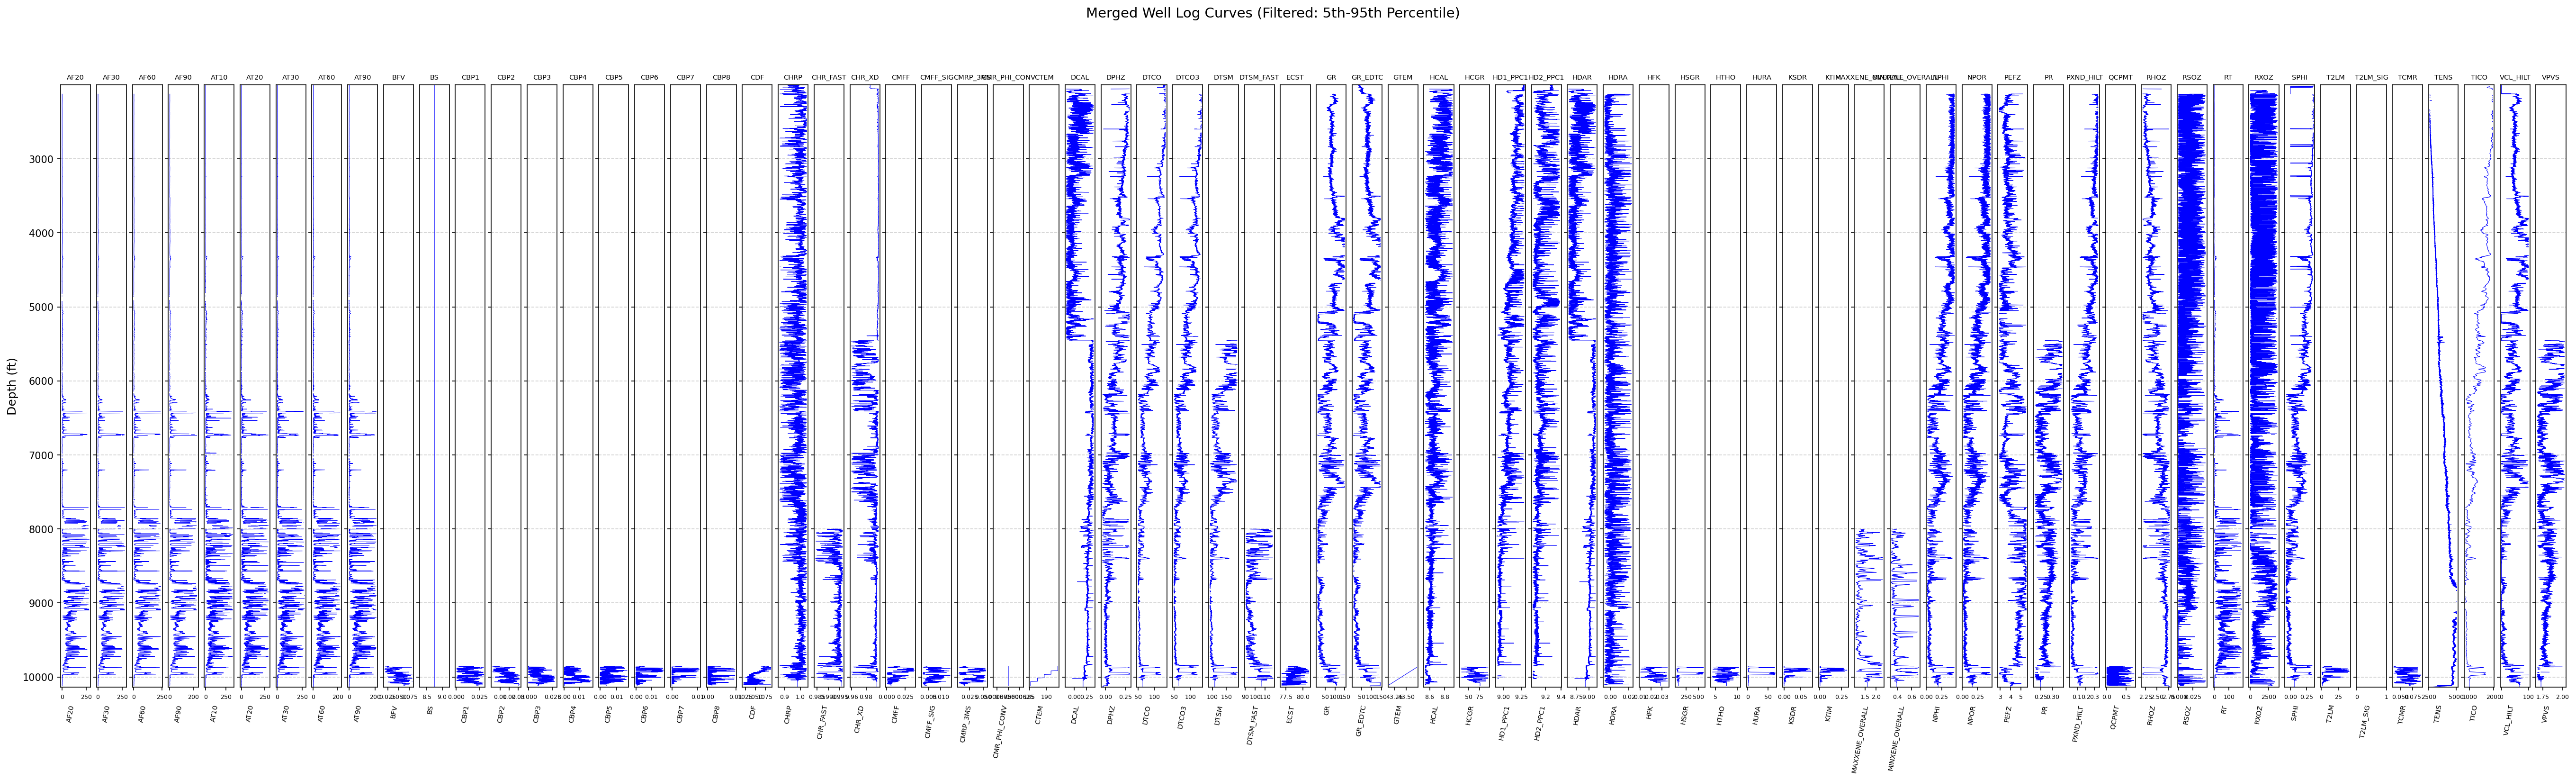

In [12]:

# Load the merged LAS file
#merged_las = lasio.read("Merged_Well_Log.las")
merged_las = lasio.read(las_filename)

# Extract depth and log curves
depth = merged_las["DEPT"]
log_curves = [curve.mnemonic for curve in merged_las.curves if curve.mnemonic != "DEPT"]

# Convert to DataFrame
df_log = merged_las.df()
df_log.index = depth  # Set depth as index

# Calculate 5th and 95th percentiles for filtering
lower_bounds = df_log.quantile(0.05)
upper_bounds = df_log.quantile(0.95)

# Filter out extreme values
df_filtered = df_log.apply(lambda col: col.where((col >= lower_bounds[col.name]) & (col <= upper_bounds[col.name]), np.nan), axis=0)

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(log_curves), figsize=(len(log_curves) * 0.65, 11), sharey=True)

# Loop through each well log curve and plot it
for i, curve in enumerate(log_curves):
    ax = axes[i]  # Assign subplot to this curve
    ax.set_title(curve, fontsize=7)

    # Check if this curve has data
    if curve in df_filtered.columns and df_filtered[curve].notna().any():
        ax.plot(df_filtered[curve], depth, linewidth=0.5, color="blue", label="Merged Data")
    #else:
    #    ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  # This is the fix
    #ax.invert_yaxis()  # Depth should increase downward
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  # Reduce x-axis tick label size
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Merged Well Log Curves (Filtered: 5th-95th Percentile)", fontsize=14)

# Save the image
'''image_filename = f"Merged_Well_Log_Plot_{well_name_cleaned}_{file_directory}.png"'''
image_filename = f"Merged_Well_Log_Plot_{well_name_cleaned}_{file_directory}_blueline_QC-check_on_merged_files.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as _{file_directory}_{image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)  # Prevent double display in Jupyter

# Embed the image inside an HTML scrollable div (keeps everything in the notebook)
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""

# Display the scrollable plot in Jupyter Notebook
display(HTML(html_code))


---
---
---
---
# **Compute Badhole flags and flag outlier on merged data.**



DCAL source: DCAL curve (DCAL)
DRHO curve used: HDRA
Percent BADHOLE_ANY:  0.16%
Percent BADHOLE_DCAL: 0.10%
Percent BADHOLE_DRHO: 0.06%


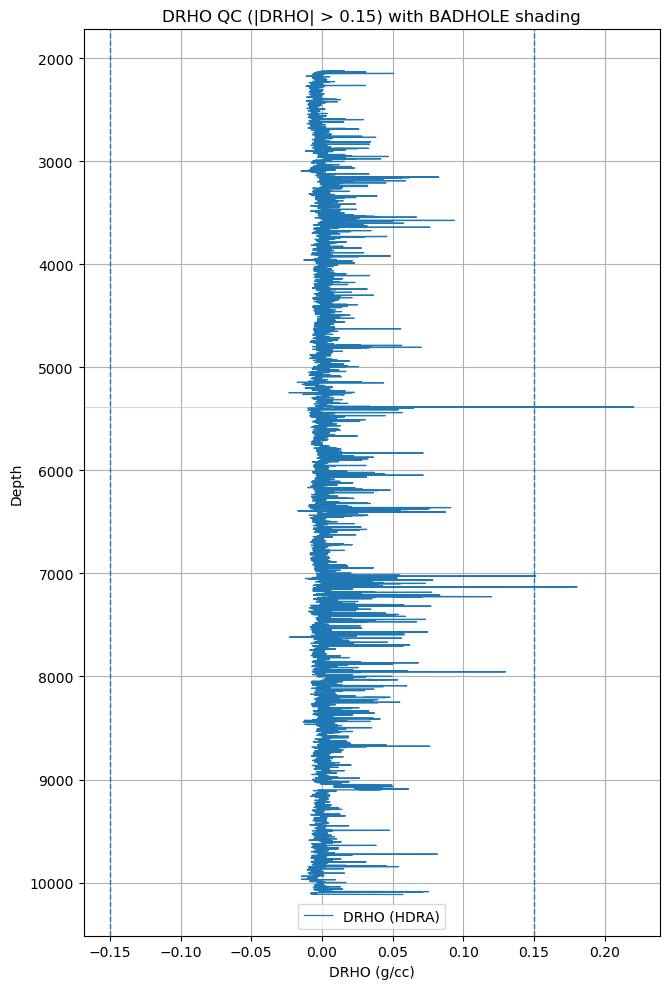

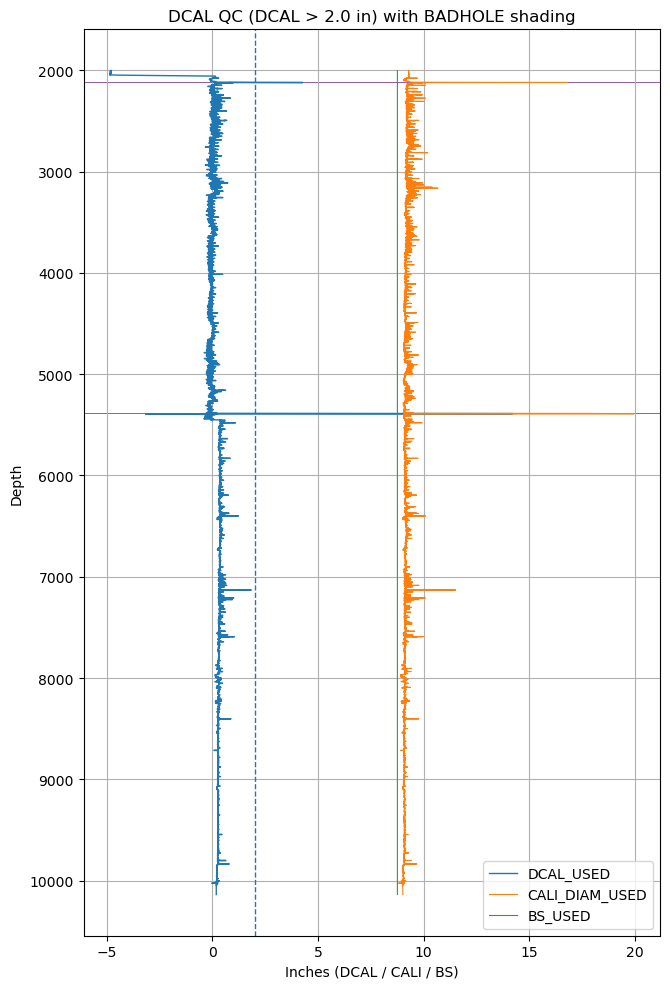

In [13]:
import numpy as np
import pandas as pd
import lasio
import matplotlib.pyplot as plt

# ============================================================
# Load MERGED well log (change filename to your merged output)
# ============================================================
merged_las = lasio.read(las_filename)


# DataFrame of curves; lasio uses depth as index by default
df = merged_las.df().copy()

# Make column names robust (strip whitespace)
df.columns = [str(c).strip() for c in df.columns]

# Depth array for plotting / masks
depth = df.index.to_numpy(dtype=float)

# ============================================================
# Curve families (merged-file logic only)
# ============================================================
curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],
    "RHOB":    ["RHOB", "RHOZ"],
    "DRHO":    ["DRHO", "DRO", "RHOC", "RHO_COR", "RHO_CORR", "RHOCOR","DENC", 
                "DENCOR", "DEN_COR", "DEN_CORR","ZCOR", "ZCORR","HDRA", "HDRH", "ECOR", "DCOR"],
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"],

    # Caliper (hole diameter, inches) — prefer the full-coverage HD curves first
    "CALI":    ["HD1_PPC1", "HD2_PPC1", "CALI", "HCAL", "C1", "C2"],

    "DCAL":    ["DCAL"],
    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],
    "RT":      ["RT", "AF90", "AT90", "AO90"],
}

# ============================================================
# Helper functions
# ============================================================
def _norm(s: str) -> str:
    return str(s).strip().upper()

def get_col_ci(df, candidates):
    """Case-insensitive + whitespace-safe column fetch. Returns actual column name or None."""
    colmap = {_norm(c): c for c in df.columns}
    for mn in candidates:
        key = _norm(mn)
        if key in colmap:
            col = colmap[key]
            if df[col].notna().any():
                return col
    return None

def get_header_constant(las, keys):
    """Try to pull a constant from LAS header (WELL/Parameter blocks). Returns float or None."""
    for k in keys:
        kk = k.strip().upper()

        # WELL block
        try:
            if kk in las.well:
                v = las.well[kk].value
                v = float(v)
                if np.isfinite(v):
                    return v
        except Exception:
            pass

        # PARAMETER block
        try:
            if hasattr(las, "params") and kk in las.params:
                v = las.params[kk].value
                v = float(v)
                if np.isfinite(v):
                    return v
        except Exception:
            pass

    return None

def build_caliper_diameter(df):
    """
    Returns a Series of hole diameter in inches.
    If both HD1_PPC1 and HD2_PPC1 exist, returns max(HD1, HD2) at each depth.
    Else returns first available caliper curve.
    """
    hd1 = get_col_ci(df, ["HD1_PPC1"])
    hd2 = get_col_ci(df, ["HD2_PPC1"])

    if hd1 is not None and hd2 is not None:
        a = pd.to_numeric(df[hd1], errors="coerce")
        b = pd.to_numeric(df[hd2], errors="coerce")
        return pd.concat([a, b], axis=1).max(axis=1)

    cali_col = get_col_ci(df, curve_families["CALI"])
    if cali_col is None:
        return None
    return pd.to_numeric(df[cali_col], errors="coerce")

def build_bit_size(df, las):
    """
    Returns a Series of BS (bit size) in inches.
    Uses BS curve if present; else tries header constants; else None.
    """
    bs_col = get_col_ci(df, curve_families["BS"])
    if bs_col is not None:
        return pd.to_numeric(df[bs_col], errors="coerce")

    bs_const = get_header_constant(las, ["BS", "BIT", "BITSIZE", "BIT_SIZE"])
    if bs_const is None:
        return None

    return pd.Series(bs_const, index=df.index, dtype=float)

def build_dcal(df, las, cali_diam, bs):
    """
    Returns (dcal_series, source_str)
    Prefers DCAL curve; else computes CALI - BS.
    """
    dcal_col = get_col_ci(df, curve_families["DCAL"])
    if dcal_col is not None:
        return pd.to_numeric(df[dcal_col], errors="coerce"), f"DCAL curve ({dcal_col})"

    if cali_diam is not None and bs is not None:
        return (cali_diam - bs), "computed (CALI - BS)"

    return None, "missing (no DCAL and cannot compute CALI - BS)"

# ============================================================
# Build merged-file derived curves: CALI_DIAM, BS_USED, DCAL_USED
# ============================================================
cali_diam = build_caliper_diameter(df)
bs_used   = build_bit_size(df, merged_las)
dcal_used, dcal_src = build_dcal(df, merged_las, cali_diam, bs_used)

# Add to df for downstream work
df["CALI_DIAM_USED"] = cali_diam
df["BS_USED"]        = bs_used
df["DCAL_USED"]      = dcal_used

# ============================================================
# Badhole thresholds (tune here)
# ============================================================
DCAL_CUTOFF_IN   = 2.0     # washout threshold (inches)
DRHO_CUTOFF_GCC  = 0.15    # density correction magnitude threshold (g/cc)

# Get DRHO
drho_col = get_col_ci(df, curve_families["DRHO"])
drho = pd.to_numeric(df[drho_col], errors="coerce") if drho_col is not None else None

# ============================================================
# Component badhole flags (merged file)
# ============================================================
df["BADHOLE_DCAL"] = False
df["BADHOLE_DRHO"] = False

if dcal_used is not None:
    df["BADHOLE_DCAL"] = (dcal_used > DCAL_CUTOFF_IN)

if drho is not None:
    df["BADHOLE_DRHO"] = (drho.abs() > DRHO_CUTOFF_GCC)

df["BADHOLE_ANY"] = (df["BADHOLE_DCAL"] | df["BADHOLE_DRHO"])

print(f"DCAL source: {dcal_src}")
print(f"DRHO curve used: {drho_col}")
print(f"Percent BADHOLE_ANY:  {100.0*df['BADHOLE_ANY'].mean():.2f}%")
print(f"Percent BADHOLE_DCAL: {100.0*df['BADHOLE_DCAL'].mean():.2f}%")
print(f"Percent BADHOLE_DRHO: {100.0*df['BADHOLE_DRHO'].mean():.2f}%")

# ============================================================
# Plot helpers (multi-color badhole shading)
# ============================================================
def shade_mask(ax, depth, mask, color, alpha=0.18, zorder=0):
    """Shade contiguous depth intervals where mask is True."""
    mask = np.asarray(mask, dtype=bool)
    if not mask.any():
        return

    in_band = False
    z0 = None
    for i in range(len(mask)):
        if mask[i] and not in_band:
            in_band = True
            z0 = depth[i]
        elif (not mask[i]) and in_band:
            in_band = False
            z1 = depth[i-1]
            ax.axhspan(min(z0, z1), max(z0, z1),
                       color=color, alpha=alpha, linewidth=0, zorder=zorder)
    if in_band:
        ax.axhspan(min(z0, depth[-1]), max(z0, depth[-1]),
                   color=color, alpha=alpha, linewidth=0, zorder=zorder)

# ============================================================
# Plot 1: DRHO QC + shading
#   blue   = BADHOLE_ANY
#   red    = BADHOLE_DRHO
# ============================================================
fig, ax = plt.subplots(1, 1, figsize=(6.8, 10))

shade_mask(ax, depth, df["BADHOLE_ANY"].values,  color="dodgerblue", alpha=0.32, zorder=0)
shade_mask(ax, depth, df["BADHOLE_DRHO"].values, color="red",       alpha=0.58, zorder=1)

if drho is not None and drho.notna().any():
    ax.plot(drho, depth, linewidth=0.9, label=f"DRHO ({drho_col})", zorder=3)
    ax.axvline(+DRHO_CUTOFF_GCC, linewidth=1.0, linestyle="--", zorder=2)
    ax.axvline(-DRHO_CUTOFF_GCC, linewidth=1.0, linestyle="--", zorder=2)

ax.invert_yaxis()
ax.set_xlabel("DRHO (g/cc)")
ax.set_ylabel("Depth")
ax.set_title(f"DRHO QC (|DRHO| > {DRHO_CUTOFF_GCC}) with BADHOLE shading")
ax.grid(True)
ax.legend(loc="best")
plt.tight_layout()
plt.show()

# ============================================================
# Plot 2: DCAL QC + shading
#   blue   = BADHOLE_ANY
#   purple = BADHOLE_DCAL
# ============================================================
fig, ax = plt.subplots(1, 1, figsize=(6.8, 10))

shade_mask(ax, depth, df["BADHOLE_ANY"].values,  color="dodgerblue", alpha=0.32, zorder=0)
shade_mask(ax, depth, df["BADHOLE_DCAL"].values, color="purple",     alpha=0.58, zorder=1)

# Plot DCAL (if available/computed)
if df["DCAL_USED"].notna().any():
    ax.plot(df["DCAL_USED"], depth, linewidth=1.0, label="DCAL_USED", zorder=3)
    ax.axvline(DCAL_CUTOFF_IN, linewidth=1.0, linestyle="--", zorder=2)

# Optional context
if df["CALI_DIAM_USED"].notna().any():
    ax.plot(df["CALI_DIAM_USED"], depth, linewidth=0.8, label="CALI_DIAM_USED", zorder=3)

if df["BS_USED"].notna().any():
    ax.plot(df["BS_USED"], depth, linewidth=0.8, label="BS_USED", zorder=3)

ax.invert_yaxis()
ax.set_xlabel("Inches (DCAL / CALI / BS)")
ax.set_ylabel("Depth")
ax.set_title(f"DCAL QC (DCAL > {DCAL_CUTOFF_IN} in) with BADHOLE shading")
ax.grid(True)
ax.legend(loc="best")
plt.tight_layout()
plt.show()


In [14]:
# --- DIAGNOSE DRHO-like curves in merged file ---
cands = [c for c in df.columns if any(k in str(c).upper() for k in ["DRHO", "HDRA", "HDRH", "RHO", "DENC", "DENCOR", "ZCOR", "CORR", "DCOR"])]
print("Possible density-correction curves found:")
print(sorted(cands))

print("\nCurrent DRHO family:", curve_families["DRHO"])
drho_col = get_col_ci(df, curve_families["DRHO"])
print("\nPicked drho_col =", drho_col)

if drho_col is not None:
    tmp = pd.to_numeric(df[drho_col], errors="coerce")
    print(tmp.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))


Possible density-correction curves found:
['BADHOLE_DRHO', 'HDRA', 'RHOZ']

Current DRHO family: ['DRHO', 'DRO', 'RHOC', 'RHO_COR', 'RHO_CORR', 'RHOCOR', 'DENC', 'DENCOR', 'DEN_COR', 'DEN_CORR', 'ZCOR', 'ZCORR', 'HDRA', 'HDRH', 'ECOR', 'DCOR']

Picked drho_col = HDRA
count    15985.000000
mean         0.003043
std          0.011989
min         -0.023300
1%          -0.008900
5%          -0.006400
50%          0.000300
95%          0.023300
99%          0.053700
max          0.220700
Name: HDRA, dtype: float64


In [15]:
drho_col = get_col_ci(df, curve_families["DRHO"])
print("Picked drho_col =", drho_col)


Picked drho_col = HDRA


# **Save all data with badhole data flags:**

In [16]:
merged_las.append_curve(
    "BADHOLE",
    df["BADHOLE_ANY"].astype(int).values,
    unit="",
    descr="1 = badhole (DCAL or DRHO)"
)

merged_las.append_curve(
    "BADHOLE_DCAL",
    df["BADHOLE_DCAL"].astype(int).values,
    unit="",
    descr="1 = badhole from DCAL washout"
)

merged_las.append_curve(
    "BADHOLE_DRHO",
    df["BADHOLE_DRHO"].astype(int).values,
    unit="",
    descr="1 = badhole from DRHO density correction"
)

las_filename2 = f"Merged_Well_Log_{well_name_cleaned}_{file_directory}_with_badhole.las"

# Write LAS file
merged_las.write(las_filename2, version=2.0, wrap=False)
print(f"Merged data saved to LAS with Badhole Flags: {las_filename2}")





#out_las = "Merged_Well_Log_with_BadHoleFlags.las"
#merged_las.write(out_las, version=2.0)
#print(f"Saved {out_las}")


Merged data saved to LAS with Badhole Flags: Merged_Well_Log_BRAAFLAT_11-11H_Bakken_with_badhole.las


In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

---
---
---
# **Experimental - Flag Badhole (black) and Outliers (red, high and low) on non-Merged Data:**


Do Not use below

In [ ]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
import base64
from io import BytesIO

# -----------------------------
# 1) Define curve families
# -----------------------------


curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],
    "RHOB":    ["RHOB", "RHOZ"],
    "DRHO":    ["DRHO", "DRO", "RHOC", "RHO_COR", "RHO_CORR", "RHOCOR","DENC", 
                "DENCOR", "DEN_COR", "DEN_CORR","ZCOR", "ZCORR","HDRA", "HDRH", "ECOR", "DCOR"],
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"],

    # Caliper (hole diameter, inches) — prefer the full-coverage HD curves first
    "CALI":    ["HD1_PPC1", "HD2_PPC1", "CALI", "HCAL", "C1", "C2"],

    "DCAL":    ["DCAL"],
    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],
    "RT":      ["RT", "AF90", "AT90", "AO90"],
}







# -----------------------------
# Robust mnemonic lookup (case-insensitive, whitespace-safe)
# -----------------------------
def _norm(s: str) -> str:
    return str(s).strip().upper()

def first_available_ci(df: pd.DataFrame, mnemonics):
    """
    Returns the *actual* df column name matching any mnemonic in mnemonics
    (case-insensitive + strips whitespace), else None.
    """
    colmap = {_norm(c): c for c in df.columns}  # normalized -> actual
    for mn in mnemonics:
        key = _norm(mn)
        if key in colmap:
            col = colmap[key]
            if df[col].notna().any():
                return col
    return None

# -----------------------------
# Compute DCAL: prefer DCAL curve, else CALI - BS
# -----------------------------
def compute_dcal(df: pd.DataFrame, debug=False):
    used = {"DCAL": None, "CALI": None, "BS": None}

    # 1) Prefer DCAL if present
    dcal_col = first_available_ci(df, curve_families.get("DCAL", []))
    if dcal_col is not None:
        used["DCAL"] = dcal_col
        dcal = pd.to_numeric(df[dcal_col], errors="coerce")
        if debug:
            print(f"DCAL: using curve '{dcal_col}'")
        return dcal, "DCAL", used

    # 2) Else compute CALI - BS (both must be in df)
    cali_col = first_available_ci(df, curve_families.get("CALI", []))
    bs_col   = first_available_ci(df, curve_families.get("BS", []))
    used["CALI"] = cali_col
    used["BS"] = bs_col

    if debug:
        print(f"DCAL: no DCAL curve; CALI candidate='{cali_col}', BS candidate='{bs_col}'")

    if cali_col is None or bs_col is None:
        return None, None, used

    cali = pd.to_numeric(df[cali_col], errors="coerce")
    bs   = pd.to_numeric(df[bs_col], errors="coerce")
    dcal_calc = cali - bs

    if debug:
        print(f"DCAL: computed as '{cali_col}' - '{bs_col}'")
    return dcal_calc, "CALI-BS", used

# -----------------------------
# Compute badhole mask
# -----------------------------
def compute_badhole_mask(df: pd.DataFrame,
                         dcal_cutoff_in=0.0,
                         drho_cutoff_gcc=0.15,
                         debug=False):
    """
    badhole = (DCAL > dcal_cutoff) OR (|DRHO| > drho_cutoff)
    DCAL is either the DCAL curve, or computed from CALI - BS.
    """
    info = {}

    dcal, dcal_src, used = compute_dcal(df, debug=debug)
    info["dcal_source"] = dcal_src
    info.update({f"used_{k.lower()}": v for k, v in used.items()})

    drho_col = first_available_ci(df, curve_families.get("DRHO", []))
    info["used_drho"] = drho_col

    mask = pd.Series(False, index=df.index)

    if dcal is not None:
        mask |= (dcal > dcal_cutoff_in)

    if drho_col is not None:
        drho = pd.to_numeric(df[drho_col], errors="coerce")
        mask |= (drho.abs() > drho_cutoff_gcc)

    mask = mask.fillna(False)

    if debug:
        pct = 100.0 * mask.mean()
        print(f"badhole: {pct:.2f}% | dcal_source={dcal_src} | DRHO='{drho_col}'")

    return mask, info

# -----------------------------
# Convert boolean mask to contiguous depth spans (for shading)
# -----------------------------
def mask_to_spans(depth, mask):
    depth = np.asarray(depth, dtype=float)
    mask  = np.asarray(mask, dtype=bool)

    spans = []
    if len(depth) == 0:
        return spans

    # ensure we walk in depth order
    order = np.argsort(depth)
    depth = depth[order]
    mask  = mask[order]

    in_span = False
    z0 = None

    for i in range(len(mask)):
        if mask[i] and not in_span:
            in_span = True
            z0 = depth[i]
        elif (not mask[i]) and in_span:
            in_span = False
            z1 = depth[i-1]
            spans.append((min(z0, z1), max(z0, z1)))

    if in_span:
        spans.append((min(z0, depth[-1]), max(z0, depth[-1])))

    return spans

# -----------------------------
# Read all LAS files (already loaded in the notebook)
# -----------------------------
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(np.nanmin(depth) for _, depth, _ in las_data)
max_depth = max(np.nanmax(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black",
              "purple", "cyan", "gray", "violet", "limegreen", "teal"]

# -----------------------------
# Precompute badhole spans ONCE per run (consistent shading across tracks)
# -----------------------------
badhole_spans_by_run = []
badhole_info_by_run  = []





for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
    # set debug=True for the run you think is failing
    badhole_mask, info = compute_badhole_mask(
        df_filtered,
        dcal_cutoff_in=2.0,
        drho_cutoff_gcc=0.15,
        debug=False
    )
    spans = mask_to_spans(depth, badhole_mask.values)
    badhole_spans_by_run.append(spans)
    badhole_info_by_run.append(info)









# -----------------------------
# Create figure with tracks for all unique curves
# -----------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(all_available_curves),
    figsize=(len(all_available_curves) * 0.65, 11),
    sharey=True
)

# Loop through each well log curve and plot it for each well
for i, curve in enumerate(all_available_curves):
    ax = axes[i]
    ax.set_title(curve, fontsize=7)

    # Apply identical badhole shading for every track
    for run_index, spans in enumerate(badhole_spans_by_run):
        for ztop, zbase in spans:
            ax.axhspan(ztop, zbase, color="dodgerblue", alpha=0.85, linewidth=0)

    has_data = False

    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth, linewidth=0.5,
                    color=run_colors[run_index % len(run_colors)])
            has_data = True

            # Visible outlier markers (10th/90th percentile)
            #lower_bound = df_filtered[curve].quantile(0.10)
            #upper_bound = df_filtered[curve].quantile(0.90)
            lower_bound = df_filtered[curve].quantile(0.001)
            upper_bound = df_filtered[curve].quantile(0.999)

            high_outliers = df_filtered[curve] > upper_bound
            low_outliers  = df_filtered[curve] < lower_bound

            ax.scatter(df_filtered.loc[high_outliers, curve], depth[high_outliers],
                       s=8, marker="o", color="red", zorder=6)
            ax.scatter(df_filtered.loc[low_outliers, curve], depth[low_outliers],
                       s=8, marker="o", color="red", zorder=6)

    if not has_data:
        ax.text(0.05, 0.5, "none", fontsize=6, color="red",
                ha="left", va="center", transform=ax.transAxes)

    ax.set_ylim(max_depth, min_depth)  # depth increases downward
    ax.set_xlabel(curve, fontsize=7, rotation=80, ha="right")
    ax.tick_params(axis="x", labelsize=6)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves with Red Outlier Markers and Blue Badhole Shading (DCAL or CALI-BS + |DRHO|)", fontsize=14)

legend_patches = [
    mpatches.Patch(color=run_colors[i % len(run_colors)], label=f"Run {i+1}: {las_files[i]}")
    for i in range(len(las_files))
]
fig.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True)

plt.tight_layout(pad=1.0, w_pad=0.2)

# Save the image
image_filename = "well_log_plot_with_outlier_badhole_shading.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)

# Embed the image inside an HTML scrollable div (keeps everything in the notebook)
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""

display(HTML(html_code))


In [ ]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
import base64
from io import BytesIO

# -----------------------------
# 1) Define curve families
# -----------------------------
'''curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],                # Gamma Ray
    "RHOB":    ["RHOB", "RHOZ"],                     # Bulk Density
    "DRHO":    ["DRHO", "HDRA", "HDRH"],             # Bulk Density Correction
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"], # Bit size
    "CALI":    ["CALI", "HCAL", "C1", "C2"],         # Caliper
    "DCAL":    ["DCAL"],                             # Differential Caliper
    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],      # Neutron Porosity
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],          # NMR porosity-family
    "RT":      ["RT", "AF90", "AT90", "AO90"],       # Deep resistivity family
}'''

curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],
    "RHOB":    ["RHOB", "RHOZ"],
    "DRHO":    ["DRHO", "HDRA", "HDRH"],
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"],

    # Caliper (hole diameter, inches) — prefer the full-coverage HD curves first
    "CALI":    ["HD1_PPC1", "HD2_PPC1", "CALI", "HCAL", "C1", "C2"],

    "DCAL":    ["DCAL"],
    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],
    "RT":      ["RT", "AF90", "AT90", "AO90"],
}






# -----------------------------
# Helpers
# -----------------------------
def first_available(df, family_key):
    for mn in curve_families.get(family_key, []):
        if mn in df.columns and df[mn].notna().any():
            return mn
    return None

def compute_dcal(df):
    """
    Prefer DCAL if present; else compute CALI - BS if possible.
    Returns: (dcal_series or None, source_str or None, used dict)
    """
    used = {"DCAL": None, "CALI": None, "BS": None}

    dcal_mn = first_available(df, "DCAL")
    if dcal_mn is not None:
        used["DCAL"] = dcal_mn
        return pd.to_numeric(df[dcal_mn], errors="coerce"), "DCAL", used

    cali_mn = first_available(df, "CALI")
    bs_mn   = first_available(df, "BS")
    used["CALI"] = cali_mn
    used["BS"]   = bs_mn

    if cali_mn is not None and bs_mn is not None:
        cali = pd.to_numeric(df[cali_mn], errors="coerce")
        bs   = pd.to_numeric(df[bs_mn], errors="coerce")
        return (cali - bs), "CALI-BS", used

    return None, None, used

def compute_badhole_mask(df, dcal_cutoff_in=2.0, drho_cutoff_gcc=0.15):
    """
    badhole = (DCAL>cutoff) OR (abs(DRHO)>cutoff)
    Uses DCAL if available else CALI-BS.
    """
    info = {}

    dcal, dcal_src, used = compute_dcal(df)
    info["dcal_source"] = dcal_src
    info.update({f"used_{k.lower()}": v for k, v in used.items()})

    drho_mn = first_available(df, "DRHO")
    info["used_drho"] = drho_mn

    mask = pd.Series(False, index=df.index)

    if dcal is not None:
        mask |= (dcal > dcal_cutoff_in)

    if drho_mn is not None:
        drho = pd.to_numeric(df[drho_mn], errors="coerce")
        mask |= (drho.abs() > drho_cutoff_gcc)

    return mask.fillna(False), info

def mask_to_spans(depth, mask):
    """
    Convert boolean mask to contiguous depth spans.
    Returns list of (z_top, z_base).
    """
    depth = np.asarray(depth, dtype=float)
    mask  = np.asarray(mask, dtype=bool)

    spans = []
    if len(depth) == 0:
        return spans

    # Ensure we walk in depth order (protect against weird ordering)
    order = np.argsort(depth)
    depth = depth[order]
    mask  = mask[order]

    in_span = False
    z0 = None

    for i in range(len(mask)):
        if mask[i] and not in_span:
            in_span = True
            z0 = depth[i]
        elif (not mask[i]) and in_span:
            in_span = False
            z1 = depth[i-1]
            spans.append((z0, z1))

    if in_span:
        spans.append((z0, depth[-1]))

    # Normalize top/base
    spans = [(min(a, b), max(a, b)) for a, b in spans]
    return spans

# -----------------------------
# Read all LAS files (already loaded in the notebook)
# -----------------------------
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black", "purple", "cyan", "gray", "violet", "limegreen", "teal"]

# -----------------------------
# Precompute badhole spans ONCE per run
# -----------------------------
badhole_spans_by_run = []
badhole_info_by_run = []





for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
    #badhole_mask, info = compute_badhole_mask(df_filtered, dcal_cutoff_in=2.0, drho_cutoff_gcc=0.15)
    badhole_mask, info = compute_badhole_mask(df_filtered, dcal_cutoff_in=2.0, drho_cutoff_gcc=0.15)
    spans = mask_to_spans(depth, badhole_mask.values)

    badhole_spans_by_run.append(spans)
    badhole_info_by_run.append(info)














# Optional sanity print (uncomment if you want)
# for i, info in enumerate(badhole_info_by_run):
#     print(f"Run {i+1}: DCAL source={info['dcal_source']}, used_dcal={info.get('used_dcal')}, "
#           f"used_cali={info.get('used_cali')}, used_bs={info.get('used_bs')}, used_drho={info.get('used_drho')} | "
#           f"spans={len(badhole_spans_by_run[i])}")

# -----------------------------
# Create figure with tracks for all unique curves
# -----------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(all_available_curves),
    figsize=(len(all_available_curves) * 0.65, 11),
    sharey=True
)

# Loop through each well log curve and plot it for each well
for i, curve in enumerate(all_available_curves):
    ax = axes[i]
    ax.set_title(curve, fontsize=7)

    # Apply identical badhole shading for every track
    for run_index, spans in enumerate(badhole_spans_by_run):
        for ztop, zbase in spans:
            ax.axhspan(ztop, zbase, color="dodgerblue", alpha=0.85, linewidth=0)

    has_data = False

    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth, linewidth=0.5,
                    color=run_colors[run_index % len(run_colors)])
            has_data = True

            # Outlier debugging (unchanged)
            #lower_bound = df_filtered[curve].quantile(0.10)
            #upper_bound = df_filtered[curve].quantile(0.90)
            lower_bound = df_filtered[curve].quantile(0.010)
            upper_bound = df_filtered[curve].quantile(0.99)

            high_outliers = df_filtered[curve] > upper_bound
            low_outliers  = df_filtered[curve] < lower_bound

            ax.vlines(df_filtered[curve][high_outliers], depth[high_outliers], depth[high_outliers],
                      color="red", linewidth=1.5)
            ax.vlines(df_filtered[curve][low_outliers], depth[low_outliers], depth[low_outliers],
                      color="red", linewidth=1.5)

    if not has_data:
        ax.text(0.05, 0.5, "none", fontsize=6, color="red",
                ha="left", va="center", transform=ax.transAxes)

    ax.set_ylim(max_depth, min_depth)
    ax.set_xlabel(curve, fontsize=7, rotation=80, ha="right")
    ax.tick_params(axis="x", labelsize=6)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves with Red Outlier Flags and Blue Badhole Shading (DCAL or CALI-BS + |DRHO|)", fontsize=14)

legend_patches = [
    mpatches.Patch(color=run_colors[i % len(run_colors)], label=f"Run {i+1}: {las_files[i]}")
    for i in range(len(las_files))
]
fig.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True)

plt.tight_layout(pad=1.0, w_pad=0.2)

# Save the image
image_filename = "well_log_plot_with_outlier_badhole_shading.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)

# Embed the image inside an HTML scrollable div
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


## More Experimental - Flag Badhole (black) and Outliers (red, high and low):

In [ ]:
## Flag Badhole (blue) and Outliers (red, high and low):


# Read all LAS files (already loaded in the notebook)
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen"]

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(all_available_curves), figsize=(len(all_available_curves) * 0.65, 11), sharey=True)

for i, curve in enumerate(all_available_curves):
    ax = axes[i]  
    ax.set_title(curve, fontsize=7)
    
    has_data = False  # Track if any data exists for the curve

    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth, linewidth=0.5, color=run_colors[run_index])
            has_data = True  

            # Calculate Outlier Thresholds (5th and 95th percentiles)
            lower_bound = df_filtered[curve].quantile(0.0001)
            upper_bound = df_filtered[curve].quantile(0.99999)

            # Identify Outlier Depths
            high_outliers = depth[df_filtered[curve] > upper_bound]
            low_outliers = depth[df_filtered[curve] < lower_bound]

            # **Plot Short Red Flag Lines for Outliers**
            for d in high_outliers:
                ax.axhline(y=d, xmin=0.0, xmax=0.15, color="red", linewidth=2)  # Short red horizontal line
            for d in low_outliers:
                ax.axhline(y=d, xmin=0.9, xmax=1.0, color="red", linewidth=2)  # Short red horizontal line

            # **Check for Borehole Washout Conditions**
            if "HCAL" in df_filtered.columns and "HDRA" in df_filtered.columns:
                badhole_mask = (df_filtered["HCAL"] > 3.5) | (df_filtered["HDRA"] > 0.3)
                badhole_depths = depth[badhole_mask]

                # **Plot Short Blue Flag Lines for Borehole Washout**
                for d in badhole_depths:
                    ax.axhline(y=d, xmin=0.0, xmax=0.1, color="blue", linewidth=1)  # Thicker blue horizontal line

    #if not has_data:
    #    ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves with Red Flags for Outliers and Blue Flags for Borehole Washout", fontsize=14)

# Save and display image
plt.tight_layout(pad=1.0, w_pad=0.2)
image_filename = "well_log_plot_flags.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig) 

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


---
---
# Updated Code Using IQR for Outliers

not implemented yet

In [ ]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
import base64
from io import BytesIO

# Read all LAS files (already loaded in the notebook)
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen"]

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(all_available_curves), figsize=(len(all_available_curves) * 0.65, 11), sharey=True)

for i, curve in enumerate(all_available_curves):
    ax = axes[i]  
    ax.set_title(curve, fontsize=7)
    
    has_data = False  # Track if any data exists for the curve

    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth, linewidth=0.5, color=run_colors[run_index])
            has_data = True  

            # **Compute IQR Outlier Thresholds**
            Q1 = df_filtered[curve].quantile(0.25)
            Q3 = df_filtered[curve].quantile(0.75)
            IQR = Q3 - Q1  # Interquartile range
            lower_bound = Q1 - 2.5 * IQR
            upper_bound = Q3 + 2.5 * IQR

            # **Identify Outlier Depths**
            high_outliers = depth[df_filtered[curve] > upper_bound]
            low_outliers = depth[df_filtered[curve] < lower_bound]

            # **Plot Short Red Flag Lines for Outliers**
            for d in high_outliers:
                ax.axhline(y=d, xmin=0.0, xmax=0.15, color="red", linewidth=2)  # Short red horizontal line
            for d in low_outliers:
                ax.axhline(y=d, xmin=0.9, xmax=1.0, color="red", linewidth=2)  # Short red horizontal line

            # **Check for Borehole Washout Conditions**
            if "DCAL" in df_filtered.columns and "HDRA" in df_filtered.columns:
                badhole_mask = (df_filtered["DCAL"] > 3.5) | (df_filtered["HDRA"] > 0.3)
                badhole_depths = depth[badhole_mask]

                # **Plot Short Blue Flag Lines for Borehole Washout**
                for d in badhole_depths:
                    ax.axhline(y=d, xmin=0.0, xmax=0.1, color="black", linewidth=2.5)  # Thicker blue horizontal line

    if not has_data:
        ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves with Red Flags for Outliers and Black Flags for Borehole Washout", fontsize=14)

# Save and display image
plt.tight_layout(pad=1.0, w_pad=0.2)
image_filename = "well_log_plot_flags_IQR_logic_needs_tuning_or_remove.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig) 

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


# Experiment with the use of the Z score Method:

(Detects extreme deviations from the mean)


In [ ]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
import base64
from io import BytesIO

# Read all LAS files (already loaded in the notebook)
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen"]

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(all_available_curves), figsize=(len(all_available_curves) * 0.65, 11), sharey=True)

for i, curve in enumerate(all_available_curves):
    ax = axes[i]  
    ax.set_title(curve, fontsize=7)
    
    has_data = False  # Track if any data exists for the curve

    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth, linewidth=0.5, color=run_colors[run_index])
            has_data = True  

            mean = df_filtered[curve].mean()
            std = df_filtered[curve].std()
            high_outliers = depth[(df_filtered[curve] - mean) / std > 4]
            low_outliers = depth[(df_filtered[curve] - mean) / std < -3]


            
            # **Plot Short Red Flag Lines for Outliers**
            for d in low_outliers:
                ax.axhline(y=d, xmin=0.0, xmax=0.15, color="red", linewidth=2)  # Short red horizontal line
            for d in high_outliers:
                ax.axhline(y=d, xmin=0.9, xmax=1.0, color="red", linewidth=2)  # Short red horizontal line

            # **Check for Borehole Washout Conditions**
            if "DCAL" in df_filtered.columns and "HDRA" in df_filtered.columns:
                badhole_mask = (df_filtered["DCAL"] > 3.5) | (df_filtered["HDRA"] > 0.3)
                badhole_depths = depth[badhole_mask]

                # **Plot Short Blue Flag Lines for Borehole Washout**
                for d in badhole_depths:
                    ax.axhline(y=d, xmin=0.0, xmax=0.1, color="black", linewidth=2.5)  # Thicker blue horizontal line

    #if not has_data:
    #    ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves with Red Flags for Z Score Outliers and Black Flags for Borehole Washout", fontsize=14)

# Save and display image
plt.tight_layout(pad=1.0, w_pad=0.2)
image_filename = "well_log_plot_flags_Z_score.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig) 

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


# Experiment with Rolling Median Absolute Deviation (MAD):

Better for detecting local anomalies in depth trends, but too sensitive. Needs to be toned down or dropped.

In [ ]:

# Read all LAS files (already loaded in the notebook)
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen"]

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(all_available_curves), figsize=(len(all_available_curves) * 0.65, 11), sharey=True)

for i, curve in enumerate(all_available_curves):
    ax = axes[i]  
    ax.set_title(curve, fontsize=7)
    
    has_data = False  # Track if any data exists for the curve

    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth, linewidth=0.5, color=run_colors[run_index])
            has_data = True  

            # **Compute Rolling MAD (Median Absolute Deviation)**
            rolling_median = df_filtered[curve].rolling(15, center=True, min_periods=1).median()  # Window size 15
            mad = np.abs(df_filtered[curve] - rolling_median).rolling(15, center=True, min_periods=1).median()

            # Define outlier threshold (3x MAD is standard)
            threshold = 5000 * mad

            # Identify Outliers (High & Low)
            high_outliers = depth[df_filtered[curve] > rolling_median + threshold]
            low_outliers = depth[df_filtered[curve] < rolling_median - threshold]

            # **Plot Short Red Flag Lines for Outliers**
            for d in high_outliers:
                ax.axhline(y=d, xmin=0.0, xmax=0.15, color="red", linewidth=2)  # Short red horizontal line
            for d in low_outliers:
                ax.axhline(y=d, xmin=0.85, xmax=1.0, color="red", linewidth=2)  # Short red horizontal line

            # **Check for Borehole Washout Conditions**
            if "DCAL" in df_filtered.columns and "HDRA" in df_filtered.columns:
                badhole_mask = (df_filtered["DCAL"] > 3.5) | (df_filtered["HDRA"] > 0.3)
                badhole_depths = depth[badhole_mask]

                # **Plot Short Blue Flag Lines for Borehole Washout**
                for d in badhole_depths:
                    ax.axhline(y=d, xmin=0.0, xmax=0.1, color="blue", linewidth=2.5)  # Thicker blue horizontal line

    #if not has_data:
    #    ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves with Red Flags for Outliers (MAD) and Blue Flags for Borehole Washout", fontsize=14)

# Save and display image
plt.tight_layout(pad=1.0, w_pad=0.2)
image_filename = "well_log_plot_flags_Median_Absolute_Deviation.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig) 

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


---
---
# **Break:** *working on exporting of data with new merged logic and at some point within depth ranges:*

In [ ]:
break


# Test Merged Data new overlap merge logic within pre-defined Depth Range at some point:

Define top and bottom depths of real data.

The depth range aspect is not working as intended

In [ ]:
top_depth = 9800
bottom_depth = 10100

# Load LAS files and extract depth ranges
las_data = []
all_curves = set()  # Store all unique log curve names

for file in las_files:
    las = lasio.read(file)
    df_log = las.df()
    df_log.index = las["DEPT"]  # Set depth as index
    top_depth = top_depth
    bottom_depth = bottom_depth
    top_depth = df_log.index.min()
    bottom_depth = df_log.index.max()
    all_curves.update(df_log.columns)  # Store all available curves
    las_data.append((file, df_log, top_depth, bottom_depth))

# Convert to sorted list (ensures order is consistent)
all_curves = sorted(list(all_curves))

# Determine Global Top and Bottom Depth
global_top_depth = min(depth for _, _, depth, _ in las_data)
global_bottom_depth = max(depth for _, _, _, depth in las_data)

print(f"Global Depth Range: {global_top_depth} ft to {global_bottom_depth} ft")

# Find merge points at the midpoint of overlapping runs
merge_points = []
for i in range(len(las_data) - 1):
    _, df1, top1, bottom1 = las_data[i]
    _, df2, top2, bottom2 = las_data[i + 1]

    overlap_top = max(top1, top2)
    overlap_bottom = min(bottom1, bottom2)

    if overlap_top < overlap_bottom:  # Ensure overlap exists
        merge_depth = (overlap_top + overlap_bottom) / 2  # Midpoint of overlap
        merge_points.append(merge_depth)

print(f"Merge Points: {merge_points}")

# Create an empty merged dataframe with a common depth index
merged_depth_index = np.arange(global_top_depth, global_bottom_depth, 0.5)  # Fine depth resolution
merged_df = pd.DataFrame(index=merged_depth_index, columns=all_curves)  # Ensure all curves are included

# Merge data based on depth range and merge points
for i, (file, df_log, top, bottom) in enumerate(las_data):
    if i == 0:
        depth_mask = (merged_depth_index <= merge_points[i]) if merge_points else np.ones_like(merged_depth_index, dtype=bool)  # First run
    elif i == len(las_data) - 1:
        depth_mask = (merged_depth_index > merge_points[i - 1])  # Last run
    else:
        depth_mask = (merged_depth_index > merge_points[i - 1]) & (merged_depth_index <= merge_points[i])  # Middle runs

    # Ensure unique depth values before reindexing
    df_log = df_log.loc[~df_log.index.duplicated(keep="first")]

    # Interpolate curves to match merged depth index
    interpolated_data = df_log.reindex(merged_depth_index).interpolate()

    # Assign to merged dataset (preserving all curves, including middle files)
    for curve in all_curves:
        if curve in interpolated_data.columns:
            merged_df[curve] = np.where(depth_mask, interpolated_data[curve], merged_df[curve])
        else:
            merged_df[curve] = merged_df[curve]  # Keep NaN if curve is absent

# Save merged data to CSV and LAS formats
merged_df.to_csv("Merged_Well_Log_using_overlap_logic.csv")
print("Merged well log data saved as Merged_Well_Log_using_overlap_logic.csv")


# Create new LAS file
las_merged = lasio.LASFile()

# Add depth curve
las_merged.curves.append(CurveItem(mnemonic="DEPT", data=merged_depth_index, unit="ft", descr="Depth"))

# Add all log curves
for curve in merged_df.columns:
    las_merged.curves.append(CurveItem(mnemonic=curve, data=merged_df[curve].values, unit="", descr=curve))

# Save merged LAS file
las_merged.write("Merged_Well_Log_using_overlap_logic.las", version=2.0)
print("Merged well log data saved as Merged_Well_Log_using_overlap_logic.las")


## Plot Merged_Well_Log.las file:

In [ ]:

# Load the merged LAS file
merged_las = lasio.read("Merged_Well_Log_using_overlap_logic.las")

# Extract depth and log curves
depth = merged_las["DEPT"]
log_curves = [curve.mnemonic for curve in merged_las.curves if curve.mnemonic != "DEPT"]

# Convert to DataFrame
df_log = merged_las.df()
df_log.index = depth  # Set depth as index

# Calculate 5th and 95th percentiles for filtering
lower_bounds = df_log.quantile(0.05)
upper_bounds = df_log.quantile(0.95)

# Filter out extreme values
df_filtered = df_log.apply(lambda col: col.where((col >= lower_bounds[col.name]) & (col <= upper_bounds[col.name]), np.nan), axis=0)

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(log_curves), figsize=(len(log_curves) * 0.65, 11), sharey=True)

# Loop through each well log curve and plot it
for i, curve in enumerate(log_curves):
    ax = axes[i]  # Assign subplot to this curve
    ax.set_title(curve, fontsize=7)

    # Check if this curve has data
    if curve in df_filtered.columns and df_filtered[curve].notna().any():
        ax.plot(df_filtered[curve], depth, linewidth=0.5, color="blue", label="Merged Data")
    else:
        ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  # This is the fix
    #ax.invert_yaxis()  # Depth should increase downward
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  # Reduce x-axis tick label size
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Merged Well Log Curves (Filtered: 5th-95th Percentile)", fontsize=14)

# Save the image
image_filename = "Merged_Well_Log_Plot.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)  # Prevent double display in Jupyter

# Embed the image inside an HTML scrollable div (keeps everything in the notebook)
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""

# Display the scrollable plot in Jupyter Notebook
display(HTML(html_code))


# **ChatGPT Method:** 
## *Used to experiment on weighted overlap merging, but all this below is not working yet. DO NOT USE TILL FULLY IMPLEMENTED.* ##

In [ ]:
break

---
---
---

## Merge with weighting within overlap region:

### **📌 Improving the Merging Process: Weighted Transition in Overlap Regions**
To ensure a **smooth transition between overlapping runs**, we should:

✅ **Favor the upper run at the top of the overlap**  
✅ **Favor the lower run at the bottom of the overlap**  
✅ **Use a weighted average transition within the overlap zone**  

---

### **✅ Solution: Apply a Weighting Function**
A **linear weighting function** can be applied:

$$
\text{Weight}_{\text{upper}} = \frac{\text{Depth} - \text{Bottom of Overlap}}{\text{Top of Overlap} - \text{Bottom of Overlap}}
$$

$$
\text{Weight}_{\text{lower}} = 1 - \text{Weight}_{\text{upper}}
$$

Where:
- **At the top of the overlap:** `Weight_upper` = **1**, `Weight_lower` = **0**
- **At the bottom of the overlap:** `Weight_upper` = **0**, `Weight_lower` = **1**
- **In the middle of the overlap:** **Smooth blend between runs**

---


In [ ]:
top_depth = 8000
bottom_depth = 10000

# Load LAS files and extract depth ranges
las_data = []
all_curves = set()  # Store all unique log curve names

for file in las_files:
    las = lasio.read(file)
    df_log = las.df()
    df_log.index = las["DEPT"]  # Set depth as index
    #top_depth = top_depth
    #bottom_depth = bottom_depth
    top_depth = df_log.index.min()
    bottom_depth = df_log.index.max()
    all_curves.update(df_log.columns)  # Store all available curves
    las_data.append((file, df_log, top_depth, bottom_depth))

# Convert to sorted list (ensures order is consistent)
all_curves = sorted(list(all_curves))

# Determine Global Top and Bottom Depth
global_top_depth = min(depth for _, _, depth, _ in las_data)
global_bottom_depth = max(depth for _, _, _, depth in las_data)

print(f"Global Depth Range: {global_top_depth} ft to {global_bottom_depth} ft")

# Find merge points at the midpoint of overlapping runs
merge_points = []
overlap_zones = []
for i in range(len(las_data) - 1):
    _, df1, top1, bottom1 = las_data[i]
    _, df2, top2, bottom2 = las_data[i + 1]

    overlap_top = max(top1, top2)
    overlap_bottom = min(bottom1, bottom2)

    if overlap_top < overlap_bottom:  # Ensure overlap exists
        merge_depth = (overlap_top + overlap_bottom) / 2  # Midpoint of overlap
        merge_points.append(merge_depth)
        overlap_zones.append((overlap_top, overlap_bottom))

print(f"Merge Points: {merge_points}")
print(f"Overlap Zones: {overlap_zones}")

# Create an empty merged dataframe with a common depth index
merged_depth_index = np.arange(global_top_depth, global_bottom_depth, 0.5)  # Fine depth resolution
merged_df = pd.DataFrame(index=merged_depth_index, columns=all_curves)  # Ensure all curves are included

# Merge data with weighted transition in overlap regions
for i, (file, df_log, top, bottom) in enumerate(las_data):
    if i == 0:
        depth_mask = pd.Series((merged_depth_index <= merge_points[i]) if merge_points else np.ones_like(merged_depth_index, dtype=bool), index=merged_depth_index)  # First run
    elif i == len(las_data) - 1:
        depth_mask = pd.Series((merged_depth_index > merge_points[i - 1]), index=merged_depth_index)  # Last run
    else:
        depth_mask = pd.Series((merged_depth_index > merge_points[i - 1]) & (merged_depth_index <= merge_points[i]), index=merged_depth_index)  # Middle runs

    # Ensure unique depth values before reindexing
    df_log = df_log.loc[~df_log.index.duplicated(keep="first")]

    # Interpolate curves to match merged depth index
    interpolated_data = df_log.reindex(merged_depth_index).interpolate()

    # Assign to merged dataset (preserving all curves, including middle files)
    for curve in all_curves:
        if curve in interpolated_data.columns:
            # Define `in_overlap` for safe usage
            in_overlap = pd.Series(np.zeros(len(merged_depth_index), dtype=bool), index=merged_depth_index)

            if i > 0:  # Handle overlaps with weighted averaging
                overlap_top, overlap_bottom = overlap_zones[i - 1]
                in_overlap = (merged_depth_index >= overlap_top) & (merged_depth_index <= overlap_bottom)

                # Compute weights
                weight_upper = (merged_depth_index - overlap_bottom) / (overlap_top - overlap_bottom)
                weight_lower = 1 - weight_upper

                # Ensure NaN handling and alignment
                merged_df[curve] = merged_df[curve].fillna(0)
                interpolated_data[curve] = interpolated_data[curve].fillna(0)

                # Apply weighted merge for overlapping depths
                merged_df.loc[in_overlap, curve] = (
                    weight_upper[in_overlap] * interpolated_data[curve][in_overlap].values +
                    weight_lower[in_overlap] * merged_df[curve][in_overlap].values
                )

            # Assign standard merge outside overlap **with proper shape alignment**
            valid_mask = depth_mask.index.intersection(merged_df.index)  # Ensure valid alignment
            merged_df.loc[valid_mask, curve] = np.where(depth_mask.loc[valid_mask], 
                                                         interpolated_data[curve].loc[valid_mask].values, 
                                                         merged_df[curve].loc[valid_mask].values)

# Save merged data to CSV and LAS formats
merged_df.to_csv("Weighted_Merged_Well_Log.csv")
print("Weighted Merged well log data saved as Merged_Well_Log.csv")

# Export as LAS
las_merged = lasio.LASFile()
las_merged.curves.append(lasio.CurveItem(mnemonic="DEPT", data=merged_depth_index, unit="ft", descr="Depth"))  # Add depth curve first
for curve in merged_df.columns:
    las_merged.curves.append(lasio.CurveItem(mnemonic=curve, data=merged_df[curve].values, unit="", descr=curve))

las_merged.write("Weighted_Merged_Well_Log.las", version=2.0)
print("Weighted Merged well log data saved as Merged_Well_Log.las")


## Plot Weighted_Merged_Well_Log.las file:

In [ ]:

# Load the merged LAS file
merged_las = lasio.read("Weighted_Merged_Well_Log.las")

# Extract depth and log curves
depth = merged_las["DEPT"]
log_curves = [curve.mnemonic for curve in merged_las.curves if curve.mnemonic != "DEPT"]

# Convert to DataFrame
df_log = merged_las.df()
df_log.index = depth  # Set depth as index

# Calculate 5th and 95th percentiles for filtering
lower_bounds = df_log.quantile(0.05)
upper_bounds = df_log.quantile(0.95)

# Filter out extreme values
df_filtered = df_log.apply(lambda col: col.where((col >= lower_bounds[col.name]) & (col <= upper_bounds[col.name]), np.nan), axis=0)

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(log_curves), figsize=(len(log_curves) * 0.65, 11), sharey=True)

# Loop through each well log curve and plot it
for i, curve in enumerate(log_curves):
    ax = axes[i]  # Assign subplot to this curve
    ax.set_title(curve, fontsize=7)

    # Check if this curve has data
    if curve in df_filtered.columns and df_filtered[curve].notna().any():
        ax.plot(df_filtered[curve], depth, linewidth=0.5, color="blue", label="Merged Data")
    else:
        ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  # This is the fix
    #######ax.invert_yaxis()  # Depth should increase downward
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  # Reduce x-axis tick label size
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Weighted Merged Well Log Curves (Filtered: 5th-95th Percentile)", fontsize=14)

# Save the image
image_filename = "Weighted_Merged_Well_Log_Plot.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)  # Prevent double display in Jupyter

# Embed the image inside an HTML scrollable div (keeps everything in the notebook)
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""

# Display the scrollable plot in Jupyter Notebook
display(HTML(html_code))
